 # Predicción de Series Temporales
 # Facebook's Prophet

## Preparing the dependent variable

In [1]:
import pandas as pd
y = pd.read_csv('../data/air_visit_data.csv.zip')
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y = y.fillna(0)
y = pd.DataFrame(y.sum(axis=1))
y.tail()


,0
visit_date,
2017-04-18,13489.0
2017-04-19,14607.0
2017-04-20,13990.0
2017-04-21,19624.0
2017-04-22,21245.0


## Preparing the modeling data frame

In [2]:
# en el paquete los datos tienen que ir de una forma exacta.
# primera columna fechas y segunda columna los datos
y = y.reset_index(drop=False)
y.columns = ['ds', 'y']
y.tail()


,ds,y
473,2017-04-18,13489.0
474,2017-04-19,14607.0
475,2017-04-20,13990.0
476,2017-04-21,19624.0
477,2017-04-22,21245.0


<AxesSubplot:>

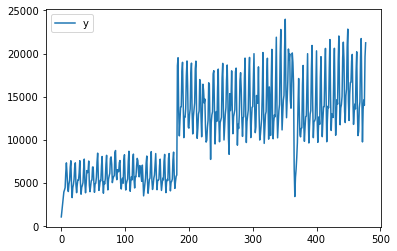

In [3]:
import matplotlib.pyplot as plt
y.plot()

## Creating a train-test split

In [4]:
# los 27 datos últimos los dejo como testeo
train = y.iloc[:450,:]
test = y.iloc[450:,:]


In [5]:
!pip install pystan==2.19.1.1

In [6]:
!pip install prophet

In [7]:
pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


## Creating a basic Prophet model
https://facebook.github.io/prophet/
# Install pystan with pip before using pip to install prophet
# pystan>=3.0 is currently not supported
pip install pystan==2.19.1.1

pip install prophet

In [8]:
from prophet import Prophet
m = Prophet()
m.fit(train)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       812.583     0.0101763       177.011    0.000139       0.001      164  LS failed, Hessian reset 
      99       812.812    0.00391398         74.28           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        813.05   0.000248612       63.3672    3.67e-06       0.001      259  LS failed, Hessian reset 
     174       813.076   9.71975e-05        74.314   1.227e-06       0.001      354  LS failed, Hessian reset 
     199       813.082   1.01931e-06       71.9617       0.926       0.926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       813.082   7.64401e-08       60.7171           1           1      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

## Creating a basic Prophet model

In [18]:
# le voy a decir que me cree el data frame para guardar los resultados y hacemos la predicción
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)


## Creating a basic Prophet model

In [10]:
from sklearn.metrics import r2_score
# vamos a calcular el valor de R^2 que indica el ajuste de la predicción
print(r2_score(list(test['y']), list(forecast.loc[450:,'yhat'] )))


0.8088634456117083


## Plotting the fit of the model

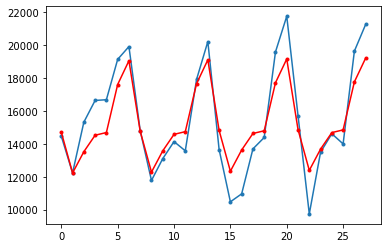

In [11]:
import matplotlib.pyplot as plt
# graficamos predicción y real
plt.plot(list(test['y']),'.-')
plt.plot(list(forecast.loc[450:,'yhat']),'r.-')
plt.show()


## Creating a Prophet forecast plot

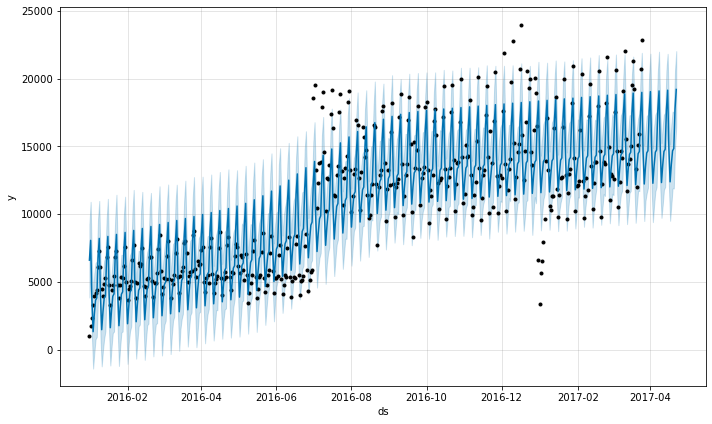

In [19]:
# gráfico de la predicción
fig1 = m.plot(forecast)
plt.show()
# los puntos son los ountos reales y lo azul la predicción

## Creating a Prophet decomposition plot

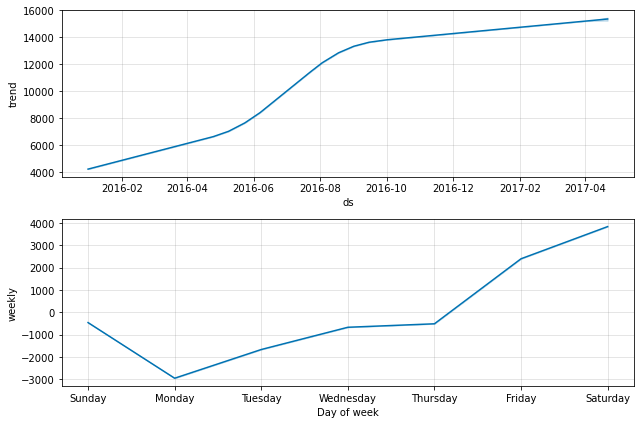

In [20]:
# suma primero la tendencia
# el segundo es el componente cíclico diario
fig2 = m.plot_components(forecast)
plt.show()


## Add montly seasonality to the plot

In [21]:
# voy a añadirle un periodo de estacionalidad mensual. Le ponemos 30.5 porque es mensual.
# ponemos 5 componentes de Fourier. Cuanto más componentes más complicado es el modelo y más ajustado será
m2 = Prophet()
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m2.fit(train)

# miro el rscore.
future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future)
print(r2_score(list(test['y']), list(forecast2.loc[450:,'yhat'] )))

# cuando añado la componente estacional mensual el modelo nos da un rscore menor.
# luego no lo debemos introducir

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       819.008   4.28174e-05       60.1845      0.7944      0.7944      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       819.406   0.000112387       46.2908   1.835e-06       0.001      252  LS failed, Hessian reset 
     199       819.736   0.000434864       71.6952      0.2636      0.7165      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       819.749   1.54002e-08       62.1759     0.05729           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
0.7906678654240866


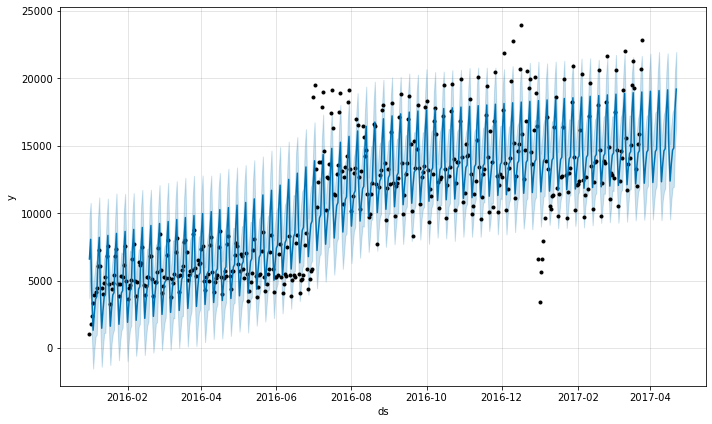

In [15]:
fig1 = m2.plot(forecast)
plt.show()

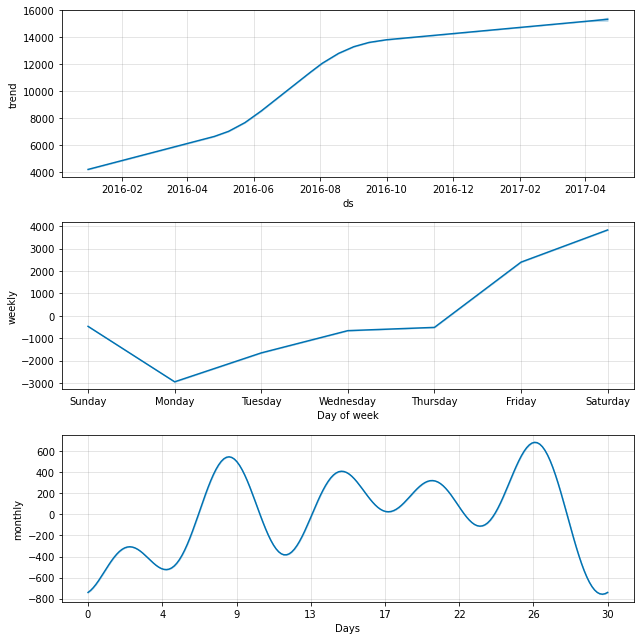

In [16]:
# componente tendencial
# componente semanal
# componente mensual (600 visitas por debajo al principio del mes. El día 8 y el 26 son los días con más
# visitas según la predicción)
fig2 = m2.plot_components(forecast2)
plt.show()


## Prepare holidays data

In [23]:
holidays = pd.read_csv('../data/date_info.csv.zip')
holidays.tail()


,calendar_date,day_of_week,holiday_flg
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


In [24]:
# voy a seleccionarme los días que sean fiesta.
holidays = holidays[holidays['holiday_flg'] == 1]
holidays = holidays[['calendar_date', 'holiday_flg']]
holidays = holidays.drop(['holiday_flg'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']
holidays.tail()

,ds,holiday
444,2017-03-20,holiday
484,2017-04-29,holiday
488,2017-05-03,holiday
489,2017-05-04,holiday
490,2017-05-05,holiday


## Add holidays to the model

In [25]:
# para que el modelo lo entienda le decimos que le metemos vacaciones.
# ahora no hemos añadido modelo mensual
m3 = Prophet(holidays=holidays)
m3.fit(train)
future3 = m3.make_future_dataframe(periods=len(test))
forecast3 = m3.predict(future)

print(r2_score(list(test['y']), list(forecast3.loc[450:,'yhat'] )))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       814.566   0.000295833       68.2921   4.575e-06       0.001      158  LS failed, Hessian reset 
      99        814.58   3.88359e-05        73.043      0.1879           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       814.594   2.64772e-06       71.0502    3.46e-08       0.001      269  LS failed, Hessian reset 
     160       814.594   7.96743e-08       69.2239      0.5494           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
0.8070102135141628


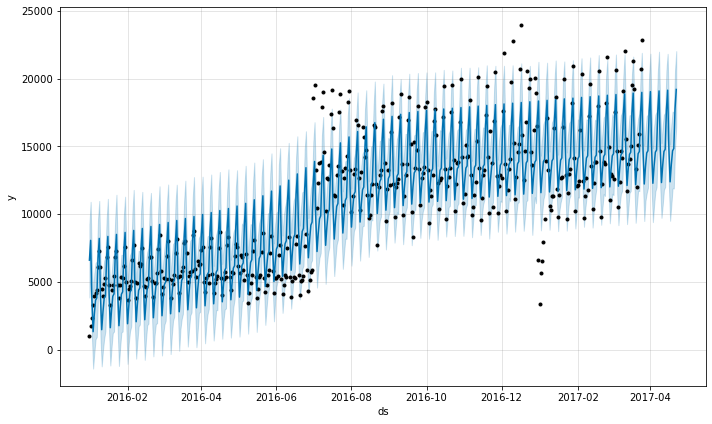

In [26]:
fig1 = m3.plot(forecast)
plt.show()

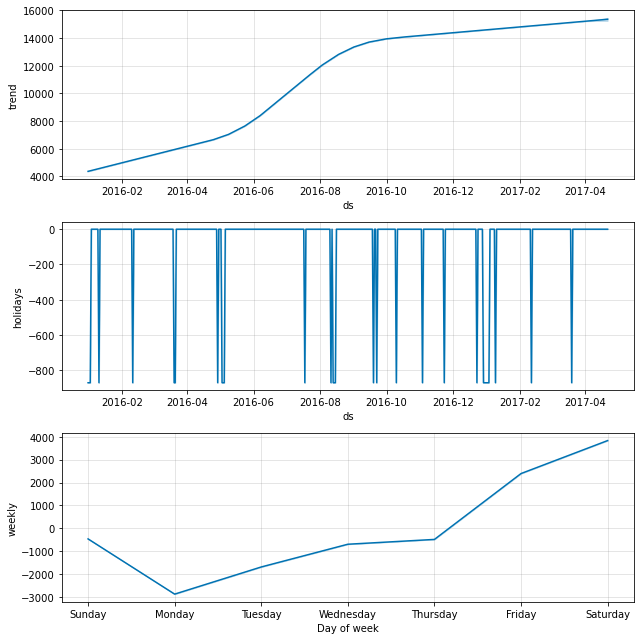

In [27]:
# nos pone el efecto de cada uno de los días de fiesta. Nos pone el mismo efecto todos los días, una caída
# de 900 más o menos
fig2 = m3.plot_components(forecast3)
plt.show()


## Add reservations to the model

In [29]:

X_reservations = pd.read_csv('../data/air_reserve.csv.zip')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)
train4 = train.copy()
train4['ds'] = pd.to_datetime(train4['ds']).dt.date
train4 = train4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'y', 'reserve_visitors']].fillna(0)
train4.tail()

,ds,y,reserve_visitors
445,2017-03-21,11987.0,1357.0
446,2017-03-22,15101.0,2071.0
447,2017-03-23,15879.0,1789.0
448,2017-03-24,20720.0,3866.0
449,2017-03-25,22836.0,3233.0


## Add reservations to the model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       847.464    0.00672188       67.7999           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        847.61    0.00362766       166.015   5.099e-05       0.001      161  LS failed, Hessian reset 
     146       848.805    0.00100053       127.907   9.076e-06       0.001      249  LS failed, Hessian reset 
     199       850.408   2.71041e-05       60.2606      0.5697      0.5697      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       850.982   0.000793899       113.083   7.898e-06       0.001      389  LS failed, Hessian reset 
     292       851.316   7.22382e-09        59.694     0.02291           1      479   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

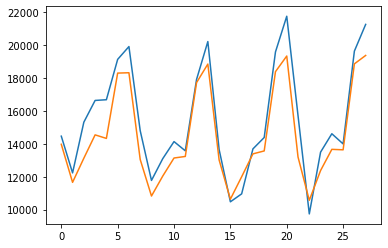

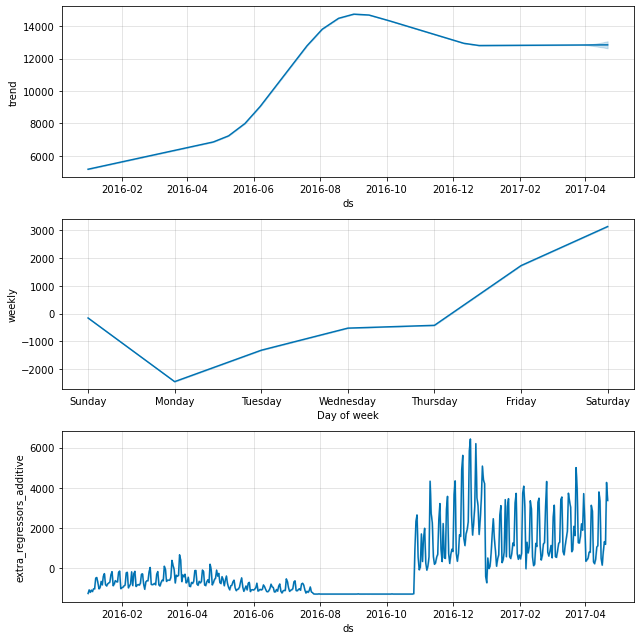

In [30]:

m4 = Prophet()
# añadimos la variable al modelo
m4.add_regressor('reserve_visitors')
m4.fit(train4)
future4 = m4.make_future_dataframe(periods=len(test))
future4['ds'] = pd.to_datetime(future4['ds']).dt.date

# necesitamos decirle cuales son las predicciones de visitas

future4 = future4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'reserve_visitors']].fillna(0)

forecast4 = m4.predict(future4)

print(r2_score(list(test['y']), list(forecast4.loc[450:,'yhat'] )))

plt.plot(list(test['y']))
plt.plot(list(forecast4.loc[450:,'yhat'] ))

fig2 = m4.plot_components(forecast4)
plt.show()

# ahora obtenemos un mayor R^2.
# Nuestra predicción ha mejorado algo con las reservas.
# el último gráfico es el efecto que tienen las reservas sobre las visitas

In [ ]:
# lo que hemos hecho es plantear componentes por separado. Lo que hacemos ahora es crear una función en la que
# ....

## Grid Searching the Prophet

In [31]:
# introduzco todos los posibles hiperparametros que tenemos que decidir
def model_test(holidays, weekly_seasonality,
yearly_seasonality, add_monthly, add_reserve, changepoint_prior_scale, holidays_prior_scale, month_fourier):
    
    m4 = Prophet(
        yearly_seasonality=yearly_seasonality, 
        weekly_seasonality=weekly_seasonality, 
        holidays=holidays, 
        changepoint_prior_scale=changepoint_prior_scale, 
        holidays_prior_scale=holidays_prior_scale)
    
    if add_monthly:    
        m4.add_seasonality(
            name='monthly', 
            period=30.5, 
            fourier_order=month_fourier)
                
    if add_reserve:
        m4.add_regressor('reserve_visitors')

    m4.fit(train4)

    future4 = m4.make_future_dataframe(periods=len(test))

    future4['ds'] = pd.to_datetime(future4['ds']).dt.date
    
    if add_reserve:
        future4 = future4.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
        future4 = future4[['ds', 'reserve_visitors']]
        future4 = future4.fillna(0)

    forecast4 = m4.predict(future4)

    return r2_score(
            list(test['y']),
            list(forecast4.loc[450:,'yhat'] )) 



In [32]:

# Setting the grid para elegir diferentes hiperparámetros
# no ejecutar tarda mucho.
# cuando lo hago, obtengo un ajuste del 92, luego es muy bueno
holidays_opt = [holidays, None]
weekly_seas = [ 5, 10, 30, 50]
yearly_seas = [ 5, 10, 30, 50]
add_monthly = [True, False]
add_reserve = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5]
month_fourier = [5, 10, 30, 50]

# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_reserve:
           for c in changepoint_prior_scale:
             for hp in holidays_prior_scale:
               for mf in month_fourier:
                  r2=model_test(h,w,ys,m,r,c,hp,mf)
                  print([w,ys,m,r,c,hp,mf,r2])
                  grid_results.append([h,w,ys,m,r,c,hp,mf,r2])

# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)

h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

# Fit the Prophet with those best hyperparameters
m4 = Prophet(
        yearly_seasonality=ys, 
        weekly_seasonality=w, 
        holidays=h, 
        changepoint_prior_scale=c, 
        holidays_prior_scale=hp)
    
if m:    
    m4.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=mf)

if r:
    m4.add_regressor('reserve_visitors')

m4.fit(train4)

future4 = m4.make_future_dataframe(periods=len(test))

future4['ds'] = pd.to_datetime(future4['ds']).dt.date

if r:
    future4 = future4.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
    future4 = future4[['ds', 'reserve_visitors']]
    future4 = future4.fillna(0)

forecast4 = m4.predict(future4)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.27   0.000195961       99.5958      0.3742      0.3742      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       1032.91    0.00121915       144.348   2.522e-05       0.001      237  LS failed, Hessian reset 
     199       1033.29   0.000244972       42.5952      0.9766      0.9766      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.24   0.000179355       21.1654      0.2813           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1034.24   1.14287e-05       32.8276    5.38e-07       0.001      461  LS failed, Hessian reset 
     325       1034.24   1.35865e-07       17.4416      0.3204           1      481   
Optimization terminat

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 5, 0.9041665429951369]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.24   0.000267066       40.0631      0.4092      0.4092      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        1031.9     0.0032717       133.635   5.202e-05       0.001      183  LS failed, Hessian reset 
     143       1032.38    0.00128386       91.3892   2.367e-05       0.001      233  LS failed, Hessian reset 
     199       1033.85    0.00234617       57.5493      0.5461      0.5461      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       1034.76   0.000294638       66.2748   4.238e-06       0.001      449  LS failed, Hessian reset 
     299       1035.02    1.9626e-05       18.1455      0.4329      0.4329      492   
    Iter      log prob        ||dx|| 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 10, 0.9020580669308161]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1049.47   0.000539754       122.255      0.6421      0.6421      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1052.52    0.00063293       74.0652           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251        1053.1    0.00247979       110.978   3.174e-05       0.001      334  LS failed, Hessian reset 
     299       1053.54   3.51931e-06       27.4792      0.4037      0.4037      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       1053.55   2.37613e-05       17.3001   7.523e-07       0.001      445  LS failed, Hessian reset 
     365       1053.55   3.21919e-05       33.9645   9.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 30, 0.9184548588502827]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1049.58    0.00432936       62.0589           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1052.44    0.00103271        41.878           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1053.12   0.000358581        76.719   5.873e-06       0.001      327  LS failed, Hessian reset 
     299       1053.48   1.69525e-05       18.6476      0.3414           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       1053.49   0.000132942        28.132   4.788e-06       0.001      496  LS failed, Hessian reset 
     361       1053.49   2.45773e-06       27.0406   1.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 50, 0.9159970959286361]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.81   0.000690084       41.2458      0.7769      0.7769      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1031.64    0.00151238       144.657   1.757e-05       0.001      164  LS failed, Hessian reset 
     199       1033.73   0.000719757       75.4528           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       1034.61   0.000279666       39.7154    6.23e-06       0.001      376  LS failed, Hessian reset 
     285       1034.62   2.33605e-05       17.2108    9.89e-07       0.001      438  LS failed, Hessian reset 
     299       1034.62    7.3006e-06       27.7658     0.05015           1      459   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 5, 0.9029045514069088]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.87    0.00988388       120.359           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       1034.15   0.000346241       58.2748   3.267e-06       0.001      265  LS failed, Hessian reset 
     199       1034.32   0.000460125       44.3862      0.4945      0.4945      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       1035.32    0.00288507       138.865   4.899e-05       0.001      420  LS failed, Hessian reset 
     299       1035.41   0.000815691       24.5012           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       1035.44   1.30309e-07       15.9118      

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 10, 0.9076642878402138]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1050.08    0.00136569       84.4555      0.1464       0.837      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       1052.21   0.000454056        99.927   3.498e-06       0.001      216  LS failed, Hessian reset 
     199       1053.06   7.43383e-05       24.4581      0.3518           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       1053.57   0.000339771       77.7042   3.225e-06       0.001      374  LS failed, Hessian reset 
     283          1054   4.95406e-05       20.0358    1.88e-06       0.001      462  LS failed, Hessian reset 
     299          1054   1.58568e-06       16.1893      0.3255           1      491   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 30, 0.9174402456860307]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1049.95    0.00164404        82.375      0.8801      0.8801      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1052.7    0.00171874       83.5465      0.7025    0.007025      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       1053.76   0.000573092       50.7617   7.115e-06       0.001      387  LS failed, Hessian reset 
     299       1053.97   3.37807e-05       24.9715      0.2537      0.9991      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       1053.98   5.29682e-09       40.7756   1.683e-05      0.1406      470   
Optimization terminated normally: 
  Convergence detected: absolute parameter c

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 50, 0.916737062035592]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.95    0.00282744       71.4505      0.7755      0.7755      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.87   0.000456595       38.1497           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.67   0.000119953       33.4684      0.3113           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.71   3.17086e-05       35.3934           1           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.73   0.000142623       25.6248           1           1      636   
    Iter    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 5, 0.9023653688499444]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.78    0.00711233       63.9594           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.63   0.000449108       63.2297      0.4298      0.4298      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1034.95    0.00100953       59.1306   1.831e-05       0.001      290  LS failed, Hessian reset 
     299       1035.54   3.04731e-05       24.6806      0.1354           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       1035.54   2.61911e-05       25.4035   1.061e-06       0.001      438  LS failed, Hessian reset 
     399       1035.56   8.91574e-05        36.708      

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 10, 0.9056381809312365]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1050.17    0.00220984       71.2783           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198        1052.8   0.000389526       78.0616   3.086e-06       0.001      265  LS failed, Hessian reset 
     199       1052.81    0.00020781       62.8658           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       1053.77    0.00138087       113.354   1.931e-05       0.001      413  LS failed, Hessian reset 
     299       1053.99   0.000180315       19.9483      0.7998      0.7998      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       1054.03   9.18649e-06       18.0867    3

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 30, 0.9176281853921346]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1049.75     0.0061372        98.678           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1052.44    0.00069654       125.628   5.898e-06       0.001      249  LS failed, Hessian reset 
     199       1053.04    0.00122286       41.7671      0.1528           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       1053.76    0.00121462       155.684   1.678e-05       0.001      385  LS failed, Hessian reset 
     299       1054.01   0.000173751       21.9949           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       1054.02   5.04931e-05       33.5971   1.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 50, 0.9178861791898452]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1034.93    0.00311896       52.0423           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1035.62    0.00319294       24.1984           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       1035.91    0.00015842       30.5777   3.046e-06       0.001      369  LS failed, Hessian reset 
     299       1035.94   2.04572e-05       13.7718      0.4466      0.4466      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1036.1   0.000481923       14.8696      0.4537      0.4537      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 5, 0.8455770794767955]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1035.55     0.0177709       36.9053      0.5346           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.39    0.00261801       39.8299      0.2712      0.2712      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       1036.48   0.000125372       24.7669   3.371e-06       0.001      280  LS failed, Hessian reset 
     299       1036.79   0.000105188       13.7995      0.5248      0.5248      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1036.82   0.000732629       31.4922   4.955e-05       0.001      470  LS failed, Hessian reset 
     399       1036.87   0.000361184       14.3237      

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 10, 0.8403000210589341]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.55    0.00524761       65.4709      0.8281      0.8281      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.41    0.00170087       78.1939           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       1054.62   0.000141111       22.2311   9.275e-06       0.001      397  LS failed, Hessian reset 
     299       1054.63   0.000134578       13.0374           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       1054.78   0.000174985       24.5814   7.651e-06       0.001      532  LS failed, Hessian reset 
     399       1054.79   0.000112621       16.0719     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 30, 0.9003067731723351]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.36    0.00106966       28.9023           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       1053.89   0.000638213       47.4003   3.733e-05       0.001      204  LS failed, Hessian reset 
     199       1054.08   0.000231314       16.2518     0.05442           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1054.47   0.000166369       31.9837   4.552e-06       0.001      391  LS failed, Hessian reset 
     299       1054.51   9.44455e-05       13.6853       0.985       0.985      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       1054.63   0.000233585       32.2132   6.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 50, 0.8980338416502618]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1035.1    0.00246861       65.8406      0.8631      0.8631      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       1035.93   0.000401528       40.4337   1.253e-05       0.001      268  LS failed, Hessian reset 
     199          1036      0.001188       16.6338           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       1036.31   0.000215962       29.7471   2.542e-06       0.001      436  LS failed, Hessian reset 
     299       1036.32   0.000334049       15.1162           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       1036.35   9.35837e-05       19.9546   4.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 5, 0.8206485808359334]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1036.02     0.0215172       57.1177           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.96   0.000318858       22.4069      0.3347           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       1037.15   0.000436923       39.2624   2.234e-05       0.001      356  LS failed, Hessian reset 
     299       1037.19   4.71399e-05        9.7398      0.7636      0.7636      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1037.41   4.49605e-05       16.1596      0.4779      0.4779      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 10, 0.8461768759621364]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.96    0.00274292       44.1574      0.7395      0.7395      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.83   0.000311614       15.0343           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       1055.13   0.000435472       79.6109   8.322e-06       0.001      375  LS failed, Hessian reset 
     299        1055.2    0.00121925       45.4833      0.8738      0.8738      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       1055.23   5.57119e-05       14.3759    4.15e-06       0.001      494  LS failed, Hessian reset 
     399       1055.24   4.11263e-05       12.7224     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 30, 0.9027279631996122]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.97   0.000470457       46.4502      0.3378      0.3378      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1054.43   4.97388e-05       11.9507   3.844e-06       0.001      211  LS failed, Hessian reset 
     199       1054.77    0.00255655       24.8517      0.9504      0.9504      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1054.78   9.57165e-05       22.4432   3.277e-06       0.001      316  LS failed, Hessian reset 
     299       1054.98   0.000187993       13.4232           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316        1055.1   0.000141156       30.5137   4.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 50, 0.9010643982323668]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1035.34    0.00050636       44.1779       0.143           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       1035.91   0.000144041       26.1081   3.034e-06       0.001      255  LS failed, Hessian reset 
     199       1036.16   0.000473384       13.3542           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       1036.37    0.00016763       25.8439   1.165e-05       0.001      403  LS failed, Hessian reset 
     299       1036.42   3.37044e-05       17.3543      0.4511      0.4511      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1036.6   0.000382672       14.9631     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 5, 0.8379059762732058]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1036.03    0.00158001       27.7158           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.84    0.00744799       45.5837      0.2748      0.2748      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       1037.18   0.000176102       29.7355   2.811e-06       0.001      377  LS failed, Hessian reset 
     299       1037.21   7.26302e-05       12.2369      0.6883      0.6883      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1037.3    0.00166562       25.2577      0.8889      0.8889      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 10, 0.8456829595255908]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1054.02    0.00495792       38.9028           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.77    0.00026085       26.9575     0.07049     0.07049      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264          1055   0.000173179       37.5359   3.272e-06       0.001      345  LS failed, Hessian reset 
     299       1055.02    1.4491e-05       10.9434      0.7767      0.7767      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       1055.21    0.00010352       19.0853   6.733e-06       0.001      475  LS failed, Hessian reset 
     399       1055.28   0.000651983       17.5975     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 30, 0.8985832264457625]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.86    0.00304118       26.2575      0.9074      0.9074      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.72    0.00200106       27.3622      0.3808           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1054.92    0.00014164       25.1595   2.483e-06       0.001      316  LS failed, Hessian reset 
     299       1055.01   7.71834e-07       11.7308      0.3944      0.3944      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       1055.12   0.000317339       68.7899   5.065e-06       0.001      503  LS failed, Hessian reset 
     399       1055.24   0.000381457       19.9713     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 50, 0.8990724823671885]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1036.28    0.00300713        23.902           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1037.04    0.00064584        22.218      0.3424      0.3424      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       1037.16   6.97108e-05       13.1293   2.927e-06       0.001      304  LS failed, Hessian reset 
     299       1037.32   0.000179764       18.5604      0.8547      0.8547      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       1037.56   0.000145094       27.8844   6.487e-06       0.001      514  LS failed, Hessian reset 
     399       1037.72   0.000584579       30.9607     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 5, 0.8010413198693708]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.08    0.00158431        42.571           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       1037.55   0.000554108       15.2074   5.329e-05       0.001      211  LS failed, Hessian reset 
     198       1037.83   0.000119185       20.4911   2.842e-06       0.001      322  LS failed, Hessian reset 
     199       1037.83   5.25187e-05       16.5548           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1038.16   0.000149235       12.5173      0.9782      0.9782      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       1038.24   0.000159085         24.65   8.7

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 10, 0.8010064390559893]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1054.76    0.00333128       40.8328           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1055.32    0.00281607       29.7302           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       1055.58   0.000147289       29.9304   4.063e-06       0.001      361  LS failed, Hessian reset 
     299       1055.68   0.000222679       20.2911      0.4629      0.4629      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1055.76   2.43853e-06       8.15027      0.6575      0.6575      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 30, 0.878225671498349]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1054.85    0.00101309       17.9321           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1055.41    0.00450348       20.5328      0.5803           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1055.64    0.00015933       35.4856   3.786e-06       0.001      354  LS failed, Hessian reset 
     299       1055.72   0.000763799       12.7442           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       1055.76   3.98827e-07       7.25954      0.7574      0.7574      478   
Optimization terminated normally: 
  Convergence detected: relative gradient mag

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 50, 0.8837817199782]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1036.81    0.00767588       78.5509      0.1892           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       1037.39   8.30809e-05       15.4678   3.242e-06       0.001      246  LS failed, Hessian reset 
     199       1037.46   0.000401948       17.0172      0.9573      0.9573      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251        1037.6   0.000101047       19.5526   5.968e-06       0.001      354  LS failed, Hessian reset 
     297       1037.68   7.34288e-05       14.8326   6.757e-06       0.001      437  LS failed, Hessian reset 
     299       1037.68   0.000256414       10.4048           1           1      439   
    Iter      log prob        ||dx||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 5, 0.7967714420203684]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.36     0.0111087       62.9477           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       1038.17    0.00018326       26.9207    1.15e-05       0.001      254  LS failed, Hessian reset 
     199       1038.21    0.00235883       37.1707           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1038.54    0.00364674       23.6446           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1038.69    0.00013607       11.6678       0.725       0.725      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 10, 0.8002384042008526]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1055.19   0.000771226       28.6252     0.07685     0.07685      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1055.83    0.00202799        22.006      0.2576           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1056.18   0.000563273       12.5137           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       1056.21   4.07607e-07       6.93928       0.152      0.7468      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 30, 0.8768578486100305]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1055.03   0.000688942       23.7685           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1055.7    0.00215371       23.4541           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1055.99     0.0178787       31.1483           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       1056.01   0.000201531       39.4247   5.604e-06       0.001      383  LS failed, Hessian reset 
     399       1056.22   6.14476e-05       8.78092           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 50, 0.880462027665906]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1036.94    0.00328276       65.0279      0.5466      0.5466      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1037.47    0.00234415       26.6588      0.9546      0.9546      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1037.77   0.000335285       9.18884           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1037.9    0.00271779       18.1067      0.8595      0.8595      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       1038.31   0.000132297       15.6348   9.808e-06       0.001      605  LS failed, Hes

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 5, 0.7862229395777904]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.58    0.00535778       83.3563           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1038.27    0.00233612        16.505           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1038.68    0.00253666       26.7661      0.4618      0.4618      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       1038.87   0.000254074       27.8761   2.335e-06       0.001      446  LS failed, Hessian reset 
     399        1039.1   0.000151555       15.6107      0.5493      0.5493      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 10, 0.7997102877151671]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1055.22    0.00727781       107.932           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1055.78    0.00208489       19.6076           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1056.07    0.00569402       24.6482      0.1961           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1056.25   9.78919e-05       9.83722           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       1056.25   1.21435e-06       8.13723      0.8253      0.8253      505   
Optimizatio

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 30, 0.8795315331162735]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1055.22    0.00563377       65.9902      0.4589           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1055.85   0.000825949       20.4421           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       1056.09   0.000135943       31.3461   4.806e-06       0.001      375  LS failed, Hessian reset 
     299       1056.11   0.000678854       19.7719           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1056.25   6.75384e-06       8.29661      0.4397      0.4397      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 50, 0.875679514523982]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.227    0.00108817       56.8355           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       942.512    0.00248647       111.802   4.624e-05       0.001      170  LS failed, Hessian reset 
     184       944.058   0.000604573       57.2543    1.81e-05       0.001      311  LS failed, Hessian reset 
     199       944.146    0.00201938       39.6209      0.3415           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       944.169   2.65491e-05       27.9368    1.08e-06       0.001      422  LS failed, Hessian reset 
     287       944.176   5.08001e-07       24.8608     0.07257           1      499   
Optimization terminated normally: 
  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 5, 0.7786860279068761]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       943.868    0.00214594       45.8314       0.306       0.901      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       945.974   0.000137205       16.8739       1.772      0.2712      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       945.976   2.57361e-05       25.1613   9.544e-07       0.001      303  LS failed, Hessian reset 
     222       945.976   5.53235e-07        16.264   2.779e-08       0.001      375  LS failed, Hessian reset 
     224       945.976   9.86514e-08       25.0389      0.1466           1      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 10, 0.7757735588448459]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        952.22   0.000459917       65.4945   5.686e-06       0.001      121  LS failed, Hessian reset 
      99       952.754     0.0085017       100.491           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       953.906   0.000533809       85.6502   5.906e-06       0.001      250  LS failed, Hessian reset 
     199       954.552    0.00112081        36.014      0.9973      0.9973      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       954.758    0.00211073       75.0448   3.637e-05       0.001      413  LS failed, Hessian reset 
     268       954.801   1.92921e-07       20.5163   1.023e-08       0.001      496  LS failed, Hessian reset 
Optimizatio

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 30, 0.7608188810920833]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.155    0.00441428       63.1322       0.137           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       953.177   0.000922718       100.416   1.462e-05       0.001      158  LS failed, Hessian reset 
     162       953.904   0.000552884       69.5851   4.389e-06       0.001      261  LS failed, Hessian reset 
     199        954.54    0.00068267       40.5272      0.7815      0.7815      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292        954.79   7.38685e-05       42.0951   1.593e-06       0.001      458  LS failed, Hessian reset 
     299        954.79    1.7901e-05       37.2711      0.8813      0.8813      465   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 50, 0.760788697193487]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        942.47    0.00179744       97.7061      0.5896      0.5896      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       942.567   0.000423251       60.8475   6.098e-06       0.001      158  LS failed, Hessian reset 
     154        943.31    0.00188833       172.782    2.23e-05       0.001      250  LS failed, Hessian reset 
     199       943.824    0.00573873       39.6098           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       943.856    0.00106193       48.0752   2.541e-05       0.001      341  LS failed, Hessian reset 
     261       944.101   0.000913002       92.5958   1.695e-05       0.001      483  LS failed, Hessian reset 
     299    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 5, 0.7818905693839019]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       944.264    0.00360412       58.0739      0.8261      0.8261      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       944.395   0.000514326       77.1652   7.998e-06       0.001      165  LS failed, Hessian reset 
     147       945.243    0.00235772       81.0877     2.4e-05       0.001      249  LS failed, Hessian reset 
     199       945.716   0.000215077         22.49      0.7331      0.7331      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       945.996   0.000388883       51.2068   5.483e-06       0.001      370  LS failed, Hessian reset 
     244       946.077    0.00019437       32.9613   5.254e-06       0.001      435  LS failed, Hessian reset 
     259    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 10, 0.7772526461272136]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.175    0.00236617       51.2036      0.9802      0.9802      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142        953.97    0.00105835       121.912   1.831e-05       0.001      201  LS failed, Hessian reset 
     199       954.643   0.000530763        40.925           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       954.826   0.000765588       47.4341   1.734e-05       0.001      339  LS failed, Hessian reset 
     299        954.89   1.12172e-05       26.0623      0.8216      0.8216      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       954.891   3.23813e-06       25.9409   1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 30, 0.7605325848278761]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.033     0.0295741       120.748           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       954.131    0.00064092       96.4259   7.921e-06       0.001      201  LS failed, Hessian reset 
     199       954.754    0.00106865       60.0019   2.015e-05       0.001      306  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       954.856    0.00046494       36.5191   1.618e-05       0.001      420  LS failed, Hessian reset 
     299       954.874    3.8306e-05       43.4656           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       954.883   3.802

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 50, 0.7608039975005075]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       941.657   0.000952025       100.264   1.555e-05       0.001      127  LS failed, Hessian reset 
      99       942.162    0.00465819       49.8874           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       944.208    0.00040181       37.1376   9.332e-06       0.001      305  LS failed, Hessian reset 
     199       944.216   6.71376e-05       33.5266           1           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       944.263   2.48249e-07       22.5711   1.268e-08       0.001      413  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 5, 0.7796879694116581]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       944.017    0.00669819       49.3287       0.256           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       944.338   0.000632742       82.0093   6.857e-06       0.001      165  LS failed, Hessian reset 
     154       945.141    0.00120452       107.543   2.141e-05       0.001      253  LS failed, Hessian reset 
     199       945.783   0.000537834       36.7256           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       946.035    0.00148434       39.8402    2.63e-05       0.001      388  LS failed, Hessian reset 
     299       946.061   3.12253e-05       36.8251           1           1      497   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 10, 0.7794106629295157]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.014    0.00214184       58.5228           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       954.178   0.000741568       65.9707   3.649e-06       0.001      222  LS failed, Hessian reset 
     199       954.664    0.00108219       58.3853      0.3213           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       954.846    0.00350533       44.4885   7.993e-05       0.001      372  LS failed, Hessian reset 
     299       954.888   1.05664e-07       20.2022     0.07524     0.07524      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       954.888   2.90145e-07       17.0233   1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 30, 0.7608145446096559]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        953.15   0.000794699       55.3658        1.69       0.169      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       954.808    0.00146651       118.388   2.508e-05       0.001      244  LS failed, Hessian reset 
     199       954.875   0.000257896       32.5402           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       954.879    4.6858e-05        21.355   1.731e-06       0.001      339  LS failed, Hessian reset 
     299       954.892   3.35734e-05       25.6503           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       954.897   9.45403e-06         23.46   2

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 50, 0.7607621353793956]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       944.901    0.00165775       23.0529      0.8581      0.8581      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       945.026   0.000227406       24.8124   1.028e-05       0.001      205  LS failed, Hessian reset 
     187       945.171   0.000328245       34.4679   1.654e-05       0.001      320  LS failed, Hessian reset 
     199       945.184   4.49223e-05       12.0957      0.4035           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       945.363     1.734e-05        11.601           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       945.381   0.000151237       21.8221   6

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 5, 0.6675791189376244]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.699     0.0124177        52.652           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       947.082   0.000548019       40.6831   2.733e-05       0.001      259  LS failed, Hessian reset 
     199       947.136   0.000730655       19.2078           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       947.214   0.000153712       10.8521      0.9627      0.9627      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       947.305    0.00297764       15.9705           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 10, 0.6593925545668601]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       954.966   0.000171441        25.156    5.48e-06       0.001      148  LS failed, Hessian reset 
      99        955.02   0.000756756       28.5808           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       955.384   0.000831812       15.5076      0.3675           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       955.445    0.00016719       24.2656   6.882e-06       0.001      419  LS failed, Hessian reset 
     299       955.474   0.000432074        11.748           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       955.481   4.37243e-07       12.6614    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 30, 0.6920948524403072]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        954.78   0.000222065        23.258   1.033e-05       0.001      126  LS failed, Hessian reset 
      99       955.003    0.00652645       15.4451           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       955.231   0.000161253       20.2312   4.493e-06       0.001      238  LS failed, Hessian reset 
     199       955.362   0.000793769       15.3367       0.537       0.537      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       955.446   0.000186896        17.924   1.355e-05       0.001      459  LS failed, Hessian reset 
     299       955.448   1.85193e-05       13.6099           1           1      477   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 50, 0.7100940980055277]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       944.928    0.00161879       26.6075      0.8182      0.8182      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        945.04   0.000116294       17.4333    8.54e-06       0.001      189  LS failed, Hessian reset 
     199       945.269   0.000193376       12.5233           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       945.351   0.000153081       20.8031   5.325e-06       0.001      348  LS failed, Hessian reset 
     299       945.453    0.00453437       21.1882      0.3617           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       945.458    0.00013146       19.5687    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 5, 0.6653869171326425]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       946.759   0.000274187        30.779   1.161e-05       0.001      148  LS failed, Hessian reset 
      99       946.769   0.000624107       16.6007           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       947.168    0.00018065       23.9166   1.062e-05       0.001      289  LS failed, Hessian reset 
     199         947.2    0.00194865       25.7586           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       947.282   0.000734516       14.5112   3.941e-05       0.001      433  LS failed, Hessian reset 
     299       947.297   0.000356884       10.5961           1           1      475   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 10, 0.6698587043746137]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       955.097    0.00127953        17.811           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       955.451   0.000828987       26.1291           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       955.536   0.000157368       15.4103   3.708e-06       0.001      390  LS failed, Hessian reset 
     299       955.556   1.21115e-05       13.7684           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       955.593   3.55844e-06       9.46424       0.277       0.277      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 30, 0.703933000190377]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       955.051    0.00404743       22.9034           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       955.437    0.00018912       11.1921           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       955.454   0.000442735        37.386   2.314e-05       0.001      309  LS failed, Hessian reset 
     299       955.511    0.00601618       15.0835           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       955.556   0.000912987       34.3565   4.129e-05       0.001      522  LS failed, Hessian reset 
     399       955.569   1.59189e-05       12.8934     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 50, 0.6918548263849114]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       944.936    0.00119445       25.0163     0.02491           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       945.303    0.00372898       24.0431           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       945.394   0.000136316       20.9303   5.608e-06       0.001      297  LS failed, Hessian reset 
     266       945.436    0.00113511       34.0354   6.974e-05       0.001      378  LS failed, Hessian reset 
     299        945.45   1.23923e-05       11.5035      0.7249      0.7249      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       945.463   0.000464865       36.3227   2

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 5, 0.647660213150683]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.727    0.00242142       46.9227           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        947.17    0.00736337       16.4401           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       947.299   9.03862e-05       14.3661    6.77e-06       0.001      396  LS failed, Hessian reset 
     299       947.302   3.24758e-05       9.58093      0.6233      0.6233      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       947.309   0.000138038       21.6185   5.732e-06       0.001      519  LS failed, Hessian reset 
     399       947.314   1.06014e-05       10.2812      

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 10, 0.6415238255400839]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        955.08   0.000639087       17.1526      0.7653      0.7653      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       955.319   0.000255968       29.1552   1.389e-05       0.001      215  LS failed, Hessian reset 
     199        955.45    0.00459451        26.449           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       955.495   0.000595208       37.3624    4.14e-05       0.001      344  LS failed, Hessian reset 
     299       955.576   0.000193419        13.212      0.3071           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       955.578   6.07978e-06       11.1113    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 30, 0.6982510519014886]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       955.037    0.00290479       26.3758       1.956      0.1956      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       955.417    0.00113373       21.5812           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       955.527   1.88121e-05       13.9045      0.2113           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       955.566   0.000237539       30.7842   1.581e-05       0.001      508  LS failed, Hessian reset 
     399       955.571   0.000277528       12.9266           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 50, 0.7043491779235947]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.145    0.00120966       14.8105           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       946.277   0.000102501       13.4193   6.011e-06       0.001      186  LS failed, Hessian reset 
     199       946.564    0.00157897       26.1978      0.3989           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       946.998   0.000612657       25.6375      0.4476      0.4476      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       947.268   0.000927833       13.0457           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 5, 0.5010235392188748]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       947.886   0.000317322       14.6601      0.9414      0.9414      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       948.327   0.000459225       19.5204   4.014e-05       0.001      284  LS failed, Hessian reset 
     199       948.328   0.000389483       24.5539           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       948.392   0.000196948       21.0591   1.232e-05       0.001      371  LS failed, Hessian reset 
     299       948.521   1.75005e-05       8.42063      0.4368      0.4368      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       949.079    0.00361943       20.0776     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 10, 0.5483290135811175]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.104    0.00428082       65.9738      0.5364      0.5364      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       956.355   0.000539988       14.2145      0.8034      0.8034      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       956.466    0.00676048       31.2646           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       956.505   7.09882e-10       14.3045   2.936e-08           1      394   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 30, 0.6195595114381469]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.066    0.00201729       23.8255           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       956.346   0.000467363       12.2277      0.7956      0.7956      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       956.405   0.000282867       16.2946   2.172e-05       0.001      324  LS failed, Hessian reset 
     299       956.435    1.7341e-06       7.12344      0.7853      0.7853      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       956.603   0.000219589       10.8445           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 50, 0.6383280398518407]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.162    0.00400236       30.7147      0.2343           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       946.657    0.00153002        10.309      0.9153      0.9153      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       946.989   8.18646e-05       7.80094      0.2041      0.2041      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       947.089   0.000150386       20.0898   1.067e-05       0.001      450  LS failed, Hessian reset 
     399       947.192    0.00193592       15.4776           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 5, 0.5544197421053294]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       947.826     0.0028573        35.569       0.556           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       947.947   0.000120938       13.4454   8.964e-06       0.001      183  LS failed, Hessian reset 
     199       948.249    0.00222429       11.3955           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       948.525   0.000240545       18.4032   1.825e-05       0.001      431  LS failed, Hessian reset 
     299       948.557    0.00030193       11.4088     0.08567           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       948.889   0.000446147       11.2886     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 10, 0.5209049437715106]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.283    0.00163381       23.8303      0.4658      0.4658      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       956.353   8.33345e-05       10.0839   9.941e-06       0.001      172  LS failed, Hessian reset 
     199       956.469   0.000277765       6.82214      0.5526      0.5526      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       956.473   0.000294857       20.0548   2.853e-05       0.001      311  LS failed, Hessian reset 
     275       956.478   7.56619e-05       8.48508   9.123e-06       0.001      450  LS failed, Hessian reset 
     299       956.479   8.27172e-06       7.54359           1           1      480   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 30, 0.6144145703426338]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        956.04    0.00622367       22.7763      0.3263           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       956.406   0.000115636       11.1199   1.312e-05       0.001      259  LS failed, Hessian reset 
     199       956.418   9.12605e-05       5.74933           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       956.537   9.43184e-05       8.16359           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       956.704   0.000510381       9.20819           1           1      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 50, 0.6411908278138543]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        946.28    0.00295482       30.6608      0.2271      0.8215      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       946.639     0.0025631       16.9933           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       947.071    0.00113798       15.2894           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       947.317    0.00186881       19.2144           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       947.447    0.00139144       10.9706           1           1      605   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


   947.51    0.00354091       22.7988      0.3825      0.3825      722   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     669       947.667   3.08664e-05       10.3302   4.032e-06       0.001      847  LS failed, Hessian reset 
     699       947.667   7.59393e-07       6.40143      0.4586      0.4586      884   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     704       947.667   4.09931e-07       8.58828      0.7314      0.7314      890   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
[5, 5, True, False, 0.5, 0.5, 5, 0.5088897492201329]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       947.924     0.0133201       35.3118           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 10, 0.5411410646512189]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.194     0.0266345       49.9537           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       956.461   4.75067e-05        8.3114           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       956.729   0.000831995       11.1327        3.64       0.364      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       956.749   7.82184e-06       9.85551      0.3128           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       956.767   1.26017e-05       7.15608           1           1      606   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 30, 0.6219818164169961]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.086    0.00957456       72.5526           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        956.47   0.000957495       16.6211           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       956.492   7.43345e-05       10.6894    5.97e-06       0.001      320  LS failed, Hessian reset 
     299       956.545    0.00713258       17.3557      0.2266      0.9009      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       956.644   0.000360911       12.1832   1.346e-05       0.001      474  LS failed, Hessian reset 
     399       956.697   0.000470151       9.73743    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 50, 0.6409934648932818]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1027.34    0.00195648       56.5993           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.23    0.00148381       81.8631           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.03   0.000846919       95.2494   1.039e-05       0.001      395  LS failed, Hessian reset 
     299       1031.15    0.00133971       37.8343           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1031.26   2.98707e-05       28.2851           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 5, 0.9080893619424326]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1027.34    0.00195648       56.5993           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.23    0.00148381       81.8631           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.03   0.000846919       95.2494   1.039e-05       0.001      395  LS failed, Hessian reset 
     299       1031.15    0.00133971       37.8343           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1031.26   2.98707e-05       28.2851           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 10, 0.9080893619424326]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1027.34    0.00195648       56.5993           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.23    0.00148381       81.8631           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.03   0.000846919       95.2494   1.039e-05       0.001      395  LS failed, Hessian reset 
     299       1031.15    0.00133971       37.8343           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1031.26   2.98707e-05       28.2851           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 30, 0.9080893619424326]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1027.34    0.00195648       56.5993           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.23    0.00148381       81.8631           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.03   0.000846919       95.2494   1.039e-05       0.001      395  LS failed, Hessian reset 
     299       1031.15    0.00133971       37.8343           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1031.26   2.98707e-05       28.2851           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 50, 0.9080893619424326]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.04    0.00328522       66.4819           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.72   0.000289805        25.056           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1031.43   9.97326e-05       23.9303      0.6574      0.6574      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       1031.58   0.000258829       54.7346   3.678e-06       0.001      437  LS failed, Hessian reset 
     399       1031.68   7.51186e-05       34.8036           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 5, 0.911230784430509]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.04    0.00328522       66.4819           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.72   0.000289805        25.056           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1031.43   9.97326e-05       23.9303      0.6574      0.6574      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       1031.58   0.000258829       54.7346   3.678e-06       0.001      437  LS failed, Hessian reset 
     399       1031.68   7.51186e-05       34.8036           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 10, 0.911230784430509]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.04    0.00328522       66.4819           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.72   0.000289805        25.056           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1031.43   9.97326e-05       23.9303      0.6574      0.6574      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       1031.58   0.000258829       54.7346   3.678e-06       0.001      437  LS failed, Hessian reset 
     399       1031.68   7.51186e-05       34.8036           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 30, 0.911230784430509]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.04    0.00328522       66.4819           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1030.72   0.000289805        25.056           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1031.43   9.97326e-05       23.9303      0.6574      0.6574      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       1031.58   0.000258829       54.7346   3.678e-06       0.001      437  LS failed, Hessian reset 
     399       1031.68   7.51186e-05       34.8036           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 50, 0.911230784430509]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.06     0.0122977        90.217      0.4034           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1029.12   0.000218245       48.6987   4.891e-06       0.001      209  LS failed, Hessian reset 
     199       1030.66   0.000636475       48.4511      0.2516      0.2516      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.58   0.000260962       58.2353   3.608e-06       0.001      410  LS failed, Hessian reset 
     295       1031.65   7.62539e-06       24.3926   4.644e-07       0.001      472  LS failed, Hessian reset 
     299       1031.65   9.99802e-06       20.6173           1           1      479   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 5, 0.9117167384392504]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.06     0.0122977        90.217      0.4034           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1029.12   0.000218245       48.6987   4.891e-06       0.001      209  LS failed, Hessian reset 
     199       1030.66   0.000636475       48.4511      0.2516      0.2516      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.58   0.000260962       58.2353   3.608e-06       0.001      410  LS failed, Hessian reset 
     295       1031.65   7.62539e-06       24.3926   4.644e-07       0.001      472  LS failed, Hessian reset 
     299       1031.65   9.99802e-06       20.6173           1           1      479   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 10, 0.9117167384392504]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.06     0.0122977        90.217      0.4034           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1029.12   0.000218245       48.6987   4.891e-06       0.001      209  LS failed, Hessian reset 
     199       1030.66   0.000636475       48.4511      0.2516      0.2516      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.58   0.000260962       58.2353   3.608e-06       0.001      410  LS failed, Hessian reset 
     295       1031.65   7.62539e-06       24.3926   4.644e-07       0.001      472  LS failed, Hessian reset 
     299       1031.65   9.99802e-06       20.6173           1           1      479   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 30, 0.9117167384392504]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1028.06     0.0122977        90.217      0.4034           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1029.12   0.000218245       48.6987   4.891e-06       0.001      209  LS failed, Hessian reset 
     199       1030.66   0.000636475       48.4511      0.2516      0.2516      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1031.58   0.000260962       58.2353   3.608e-06       0.001      410  LS failed, Hessian reset 
     295       1031.65   7.62539e-06       24.3926   4.644e-07       0.001      472  LS failed, Hessian reset 
     299       1031.65   9.99802e-06       20.6173           1           1      479   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 50, 0.9117167384392504]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.92    0.00168411       29.0416           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1032.47   0.000176157       31.4808   4.068e-06       0.001      293  LS failed, Hessian reset 
     199       1032.51   0.000985506       62.8982      0.3027           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       1032.87   0.000379917       28.0914    1.07e-05       0.001      437  LS failed, Hessian reset 
     299       1032.93   0.000119219       12.1909       0.488       0.488      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.02   0.000139312       15.6343    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 5, 0.8470751262994118]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.92    0.00168411       29.0416           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1032.47   0.000176157       31.4808   4.068e-06       0.001      293  LS failed, Hessian reset 
     199       1032.51   0.000985506       62.8982      0.3027           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       1032.87   0.000379917       28.0914    1.07e-05       0.001      437  LS failed, Hessian reset 
     299       1032.93   0.000119219       12.1909       0.488       0.488      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.02   0.000139312       15.6343     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 10, 0.8470751262994118]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.92    0.00168411       29.0416           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1032.47   0.000176157       31.4808   4.068e-06       0.001      293  LS failed, Hessian reset 
     199       1032.51   0.000985506       62.8982      0.3027           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       1032.87   0.000379917       28.0914    1.07e-05       0.001      437  LS failed, Hessian reset 
     299       1032.93   0.000119219       12.1909       0.488       0.488      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.02   0.000139312       15.6343    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 30, 0.8470751262994118]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.92    0.00168411       29.0416           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       1032.47   0.000176157       31.4808   4.068e-06       0.001      293  LS failed, Hessian reset 
     199       1032.51   0.000985506       62.8982      0.3027           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       1032.87   0.000379917       28.0914    1.07e-05       0.001      437  LS failed, Hessian reset 
     299       1032.93   0.000119219       12.1909       0.488       0.488      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.02   0.000139312       15.6343    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 50, 0.8470751262994118]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.34    0.00335222       37.6445           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.16   0.000999202       16.6465           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.27   0.000136522       22.9858   8.104e-06       0.001      322  LS failed, Hessian reset 
     287       1033.33   0.000101594       23.0742   4.681e-06       0.001      439  LS failed, Hessian reset 
     299       1033.36   0.000119155       16.9882      0.9011      0.9011      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.51   2.51624e-05       12.0731    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 5, 0.8466482599294567]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.34    0.00335222       37.6445           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.16   0.000999202       16.6465           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.27   0.000136522       22.9858   8.104e-06       0.001      322  LS failed, Hessian reset 
     287       1033.33   0.000101594       23.0742   4.681e-06       0.001      439  LS failed, Hessian reset 
     299       1033.36   0.000119155       16.9882      0.9011      0.9011      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.51   2.51624e-05       12.0731     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 10, 0.8466482599294567]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.34    0.00335222       37.6445           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.16   0.000999202       16.6465           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.27   0.000136522       22.9858   8.104e-06       0.001      322  LS failed, Hessian reset 
     287       1033.33   0.000101594       23.0742   4.681e-06       0.001      439  LS failed, Hessian reset 
     299       1033.36   0.000119155       16.9882      0.9011      0.9011      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.51   2.51624e-05       12.0731    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 30, 0.8466482599294567]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1032.34    0.00335222       37.6445           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.16   0.000999202       16.6465           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       1033.27   0.000136522       22.9858   8.104e-06       0.001      322  LS failed, Hessian reset 
     287       1033.33   0.000101594       23.0742   4.681e-06       0.001      439  LS failed, Hessian reset 
     299       1033.36   0.000119155       16.9882      0.9011      0.9011      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1033.51   2.51624e-05       12.0731    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 50, 0.8466482599294567]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1032.3      0.010416       52.1283      0.3705           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.24     0.0006277       56.3658      0.7785      0.7785      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       1033.37    0.00037225       44.9833   1.487e-05       0.001      322  LS failed, Hessian reset 
     299       1033.42   9.47679e-06       13.3627      0.2926      0.2926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1033.52   8.93099e-05       19.8543   4.653e-06       0.001      472  LS failed, Hessian reset 
     393       1033.61    0.00053795        23.757    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 5, 0.8524210956553752]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1032.3      0.010416       52.1283      0.3705           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.24     0.0006277       56.3658      0.7785      0.7785      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       1033.37    0.00037225       44.9833   1.487e-05       0.001      322  LS failed, Hessian reset 
     299       1033.42   9.47679e-06       13.3627      0.2926      0.2926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1033.52   8.93099e-05       19.8543   4.653e-06       0.001      472  LS failed, Hessian reset 
     393       1033.61    0.00053795        23.757    3

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 10, 0.8524210956553752]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1032.3      0.010416       52.1283      0.3705           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.24     0.0006277       56.3658      0.7785      0.7785      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       1033.37    0.00037225       44.9833   1.487e-05       0.001      322  LS failed, Hessian reset 
     299       1033.42   9.47679e-06       13.3627      0.2926      0.2926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1033.52   8.93099e-05       19.8543   4.653e-06       0.001      472  LS failed, Hessian reset 
     393       1033.61    0.00053795        23.757    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 30, 0.8524210956553752]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1032.3      0.010416       52.1283      0.3705           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.24     0.0006277       56.3658      0.7785      0.7785      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       1033.37    0.00037225       44.9833   1.487e-05       0.001      322  LS failed, Hessian reset 
     299       1033.42   9.47679e-06       13.3627      0.2926      0.2926      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       1033.52   8.93099e-05       19.8543   4.653e-06       0.001      472  LS failed, Hessian reset 
     393       1033.61    0.00053795        23.757    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 50, 0.8524210956553752]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.04    0.00104978       20.1743      0.8322      0.8322      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.81    0.00982079       31.5274           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.26   0.000382896       11.8322           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.49    0.00018675       10.5406      0.8917      0.8917      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.64     0.0202721       36.3005           1           1      588   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 5, 0.7919722608782834]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.04    0.00104978       20.1743      0.8322      0.8322      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.81    0.00982079       31.5274           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.26   0.000382896       11.8322           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.49    0.00018675       10.5406      0.8917      0.8917      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.64     0.0202721       36.3005           1           1      588   
    Iter   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 10, 0.7919722608782834]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.04    0.00104978       20.1743      0.8322      0.8322      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.81    0.00982079       31.5274           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.26   0.000382896       11.8322           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.49    0.00018675       10.5406      0.8917      0.8917      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.64     0.0202721       36.3005           1           1      588   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 30, 0.7919722608782834]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.04    0.00104978       20.1743      0.8322      0.8322      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1033.81    0.00982079       31.5274           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.26   0.000382896       11.8322           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1034.49    0.00018675       10.5406      0.8917      0.8917      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1034.64     0.0202721       36.3005           1           1      588   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 50, 0.7919722608782834]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.56    0.00663323       26.0713       2.719      0.2719      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.5    0.00433231       26.6996           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1034.8   0.000630207       12.2246           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394        1035.2   0.000194236       36.9149   7.206e-06       0.001      509  LS failed, Hessian reset 
     399       1035.23    0.00129352        22.318           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 5, 0.7920171315471831]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.56    0.00663323       26.0713       2.719      0.2719      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.5    0.00433231       26.6996           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1034.8   0.000630207       12.2246           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394        1035.2   0.000194236       36.9149   7.206e-06       0.001      509  LS failed, Hessian reset 
     399       1035.23    0.00129352        22.318           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 10, 0.7920171315471831]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.56    0.00663323       26.0713       2.719      0.2719      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.5    0.00433231       26.6996           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1034.8   0.000630207       12.2246           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394        1035.2   0.000194236       36.9149   7.206e-06       0.001      509  LS failed, Hessian reset 
     399       1035.23    0.00129352        22.318           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 30, 0.7920171315471831]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.56    0.00663323       26.0713       2.719      0.2719      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1034.5    0.00433231       26.6996           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1034.8   0.000630207       12.2246           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394        1035.2   0.000194236       36.9149   7.206e-06       0.001      509  LS failed, Hessian reset 
     399       1035.23    0.00129352        22.318           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 50, 0.7920171315471831]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.63    0.00118751       37.4248      0.2897      0.2897      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.46    0.00153826       12.0448           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.81     0.0012461       24.7487      0.4012           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       1035.03    0.00043036       79.2899   5.692e-06       0.001      464  LS failed, Hessian reset 
     399        1035.2    0.00519241       62.5273           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 5, 0.7912124432786751]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.63    0.00118751       37.4248      0.2897      0.2897      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.46    0.00153826       12.0448           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.81     0.0012461       24.7487      0.4012           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       1035.03    0.00043036       79.2899   5.692e-06       0.001      464  LS failed, Hessian reset 
     399        1035.2    0.00519241       62.5273           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 10, 0.7912124432786751]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.63    0.00118751       37.4248      0.2897      0.2897      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.46    0.00153826       12.0448           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.81     0.0012461       24.7487      0.4012           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       1035.03    0.00043036       79.2899   5.692e-06       0.001      464  LS failed, Hessian reset 
     399        1035.2    0.00519241       62.5273           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 30, 0.7912124432786751]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1033.63    0.00118751       37.4248      0.2897      0.2897      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.46    0.00153826       12.0448           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1034.81     0.0012461       24.7487      0.4012           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       1035.03    0.00043036       79.2899   5.692e-06       0.001      464  LS failed, Hessian reset 
     399        1035.2    0.00519241       62.5273           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 50, 0.7912124432786751]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        933.17    0.00742002       56.5147       0.698      0.9742      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        933.99    0.00145412       119.471   1.466e-05       0.001      196  LS failed, Hessian reset 
     199       934.543    0.00255091       51.3967           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       934.696   0.000605172       34.7882    1.29e-05       0.001      345  LS failed, Hessian reset 
     287       934.713   5.63222e-08       23.8356     0.02801           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 5, 0.8006846211640337]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        933.17    0.00742002       56.5147       0.698      0.9742      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        933.99    0.00145412       119.471   1.466e-05       0.001      196  LS failed, Hessian reset 
     199       934.543    0.00255091       51.3967           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       934.696   0.000605172       34.7882    1.29e-05       0.001      345  LS failed, Hessian reset 
     287       934.713   5.63222e-08       23.8356     0.02801           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 10, 0.8006846211640337]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        933.17    0.00742002       56.5147       0.698      0.9742      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        933.99    0.00145412       119.471   1.466e-05       0.001      196  LS failed, Hessian reset 
     199       934.543    0.00255091       51.3967           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       934.696   0.000605172       34.7882    1.29e-05       0.001      345  LS failed, Hessian reset 
     287       934.713   5.63222e-08       23.8356     0.02801           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 30, 0.8006846211640337]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        933.17    0.00742002       56.5147       0.698      0.9742      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        933.99    0.00145412       119.471   1.466e-05       0.001      196  LS failed, Hessian reset 
     199       934.543    0.00255091       51.3967           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       934.696   0.000605172       34.7882    1.29e-05       0.001      345  LS failed, Hessian reset 
     287       934.713   5.63222e-08       23.8356     0.02801           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 50, 0.8006846211640337]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       933.084   0.000677558       90.0248    7.56e-06       0.001      157  LS failed, Hessian reset 
      99        933.11   0.000427429       75.7756           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       933.925   0.000514854       75.1092   7.369e-06       0.001      283  LS failed, Hessian reset 
     199        934.38     7.596e-05        39.299      0.3735      0.3735      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       934.725    0.00153111       79.3319   3.048e-05       0.001      425  LS failed, Hessian reset 
     270       934.804   5.47592e-05       22.1339   2.881e-06       0.001      479  LS failed, Hessian reset 
     290  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 5, 0.7966222372743199]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       933.084   0.000677558       90.0248    7.56e-06       0.001      157  LS failed, Hessian reset 
      99        933.11   0.000427429       75.7756           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       933.925   0.000514854       75.1092   7.369e-06       0.001      283  LS failed, Hessian reset 
     199        934.38     7.596e-05        39.299      0.3735      0.3735      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       934.725    0.00153111       79.3319   3.048e-05       0.001      425  LS failed, Hessian reset 
     270       934.804   5.47592e-05       22.1339   2.881e-06       0.001      479  LS failed, Hessian reset 
     290   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 10, 0.7966222372743199]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       933.084   0.000677558       90.0248    7.56e-06       0.001      157  LS failed, Hessian reset 
      99        933.11   0.000427429       75.7756           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       933.925   0.000514854       75.1092   7.369e-06       0.001      283  LS failed, Hessian reset 
     199        934.38     7.596e-05        39.299      0.3735      0.3735      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       934.725    0.00153111       79.3319   3.048e-05       0.001      425  LS failed, Hessian reset 
     270       934.804   5.47592e-05       22.1339   2.881e-06       0.001      479  LS failed, Hessian reset 
     290  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 30, 0.7966222372743199]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       933.084   0.000677558       90.0248    7.56e-06       0.001      157  LS failed, Hessian reset 
      99        933.11   0.000427429       75.7756           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       933.925   0.000514854       75.1092   7.369e-06       0.001      283  LS failed, Hessian reset 
     199        934.38     7.596e-05        39.299      0.3735      0.3735      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       934.725    0.00153111       79.3319   3.048e-05       0.001      425  LS failed, Hessian reset 
     270       934.804   5.47592e-05       22.1339   2.881e-06       0.001      479  LS failed, Hessian reset 
     290  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 50, 0.7966222372743199]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       933.003     0.0140309       84.3539           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       933.169    0.00198644       88.3871   2.596e-05       0.001      167  LS failed, Hessian reset 
     153       933.991    0.00132593       138.058    1.42e-05       0.001      268  LS failed, Hessian reset 
     199       934.498      0.002633        35.621           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        934.59   0.000695196       91.7968    1.15e-05       0.001      395  LS failed, Hessian reset 
     299       934.806   0.000122335       42.6979           1           1      486   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 5, 0.8008760214649822]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       933.003     0.0140309       84.3539           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       933.169    0.00198644       88.3871   2.596e-05       0.001      167  LS failed, Hessian reset 
     153       933.991    0.00132593       138.058    1.42e-05       0.001      268  LS failed, Hessian reset 
     199       934.498      0.002633        35.621           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        934.59   0.000695196       91.7968    1.15e-05       0.001      395  LS failed, Hessian reset 
     299       934.806   0.000122335       42.6979           1           1      486   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 10, 0.8008760214649822]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       933.003     0.0140309       84.3539           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       933.169    0.00198644       88.3871   2.596e-05       0.001      167  LS failed, Hessian reset 
     153       933.991    0.00132593       138.058    1.42e-05       0.001      268  LS failed, Hessian reset 
     199       934.498      0.002633        35.621           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        934.59   0.000695196       91.7968    1.15e-05       0.001      395  LS failed, Hessian reset 
     299       934.806   0.000122335       42.6979           1           1      486   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 30, 0.8008760214649822]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       933.003     0.0140309       84.3539           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       933.169    0.00198644       88.3871   2.596e-05       0.001      167  LS failed, Hessian reset 
     153       933.991    0.00132593       138.058    1.42e-05       0.001      268  LS failed, Hessian reset 
     199       934.498      0.002633        35.621           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        934.59   0.000695196       91.7968    1.15e-05       0.001      395  LS failed, Hessian reset 
     299       934.806   0.000122335       42.6979           1           1      486   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 50, 0.8008760214649822]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.276    0.00262537       28.3166           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       935.565   0.000332694       30.3304   1.904e-05       0.001      247  LS failed, Hessian reset 
     199       935.586   8.85215e-05       10.7836      0.2625           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       935.672    0.00024518       23.4583   2.296e-05       0.001      364  LS failed, Hessian reset 
     299       935.757   0.000612481       9.82707           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       935.812   0.000180498       10.4586   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 5, 0.6706886044571054]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.276    0.00262537       28.3166           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       935.565   0.000332694       30.3304   1.904e-05       0.001      247  LS failed, Hessian reset 
     199       935.586   8.85215e-05       10.7836      0.2625           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       935.672    0.00024518       23.4583   2.296e-05       0.001      364  LS failed, Hessian reset 
     299       935.757   0.000612481       9.82707           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       935.812   0.000180498       10.4586    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 10, 0.6706886044571054]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.276    0.00262537       28.3166           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       935.565   0.000332694       30.3304   1.904e-05       0.001      247  LS failed, Hessian reset 
     199       935.586   8.85215e-05       10.7836      0.2625           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       935.672    0.00024518       23.4583   2.296e-05       0.001      364  LS failed, Hessian reset 
     299       935.757   0.000612481       9.82707           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       935.812   0.000180498       10.4586   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 30, 0.6706886044571054]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.276    0.00262537       28.3166           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       935.565   0.000332694       30.3304   1.904e-05       0.001      247  LS failed, Hessian reset 
     199       935.586   8.85215e-05       10.7836      0.2625           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       935.672    0.00024518       23.4583   2.296e-05       0.001      364  LS failed, Hessian reset 
     299       935.757   0.000612481       9.82707           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       935.812   0.000180498       10.4586   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 50, 0.6706886044571054]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93         935.4   0.000236833       22.8251   1.158e-05       0.001      152  LS failed, Hessian reset 
      99       935.434    0.00042908       31.8571      0.2959      0.2959      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       935.469   0.000315689        14.967   3.289e-05       0.001      206  LS failed, Hessian reset 
     162       935.643   0.000131359       17.5556   6.171e-06       0.001      298  LS failed, Hessian reset 
     199       935.679    0.00014043       12.4467      0.7537      0.7537      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       935.765   0.000180157       22.7755   5.555e-06       0.001      394  LS failed, Hessian reset 
     273  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 5, 0.6644123022887596]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93         935.4   0.000236833       22.8251   1.158e-05       0.001      152  LS failed, Hessian reset 
      99       935.434    0.00042908       31.8571      0.2959      0.2959      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       935.469   0.000315689        14.967   3.289e-05       0.001      206  LS failed, Hessian reset 
     162       935.643   0.000131359       17.5556   6.171e-06       0.001      298  LS failed, Hessian reset 
     199       935.679    0.00014043       12.4467      0.7537      0.7537      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       935.765   0.000180157       22.7755   5.555e-06       0.001      394  LS failed, Hessian reset 
     273   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 10, 0.6644123022887596]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93         935.4   0.000236833       22.8251   1.158e-05       0.001      152  LS failed, Hessian reset 
      99       935.434    0.00042908       31.8571      0.2959      0.2959      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       935.469   0.000315689        14.967   3.289e-05       0.001      206  LS failed, Hessian reset 
     162       935.643   0.000131359       17.5556   6.171e-06       0.001      298  LS failed, Hessian reset 
     199       935.679    0.00014043       12.4467      0.7537      0.7537      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       935.765   0.000180157       22.7755   5.555e-06       0.001      394  LS failed, Hessian reset 
     273  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 30, 0.6644123022887596]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93         935.4   0.000236833       22.8251   1.158e-05       0.001      152  LS failed, Hessian reset 
      99       935.434    0.00042908       31.8571      0.2959      0.2959      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       935.469   0.000315689        14.967   3.289e-05       0.001      206  LS failed, Hessian reset 
     162       935.643   0.000131359       17.5556   6.171e-06       0.001      298  LS failed, Hessian reset 
     199       935.679    0.00014043       12.4467      0.7537      0.7537      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       935.765   0.000180157       22.7755   5.555e-06       0.001      394  LS failed, Hessian reset 
     273  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 50, 0.6644123022887596]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.368     0.0019348       25.9717           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       935.446   0.000150841       17.6064   7.477e-06       0.001      181  LS failed, Hessian reset 
     199       935.756    0.00760017       23.5589       0.664       0.664      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       935.866   0.000243037       23.6941   1.292e-05       0.001      410  LS failed, Hessian reset 
     299       935.887   0.000104075       8.75058       2.013      0.2013      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       935.896   8.92184e-05       11.1711   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 5, 0.6877953213471087]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.368     0.0019348       25.9717           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       935.446   0.000150841       17.6064   7.477e-06       0.001      181  LS failed, Hessian reset 
     199       935.756    0.00760017       23.5589       0.664       0.664      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       935.866   0.000243037       23.6941   1.292e-05       0.001      410  LS failed, Hessian reset 
     299       935.887   0.000104075       8.75058       2.013      0.2013      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       935.896   8.92184e-05       11.1711   6

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 10, 0.6877953213471087]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.368     0.0019348       25.9717           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       935.446   0.000150841       17.6064   7.477e-06       0.001      181  LS failed, Hessian reset 
     199       935.756    0.00760017       23.5589       0.664       0.664      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       935.866   0.000243037       23.6941   1.292e-05       0.001      410  LS failed, Hessian reset 
     299       935.887   0.000104075       8.75058       2.013      0.2013      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       935.896   8.92184e-05       11.1711   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 30, 0.6877953213471087]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       935.368     0.0019348       25.9717           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       935.446   0.000150841       17.6064   7.477e-06       0.001      181  LS failed, Hessian reset 
     199       935.756    0.00760017       23.5589       0.664       0.664      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       935.866   0.000243037       23.6941   1.292e-05       0.001      410  LS failed, Hessian reset 
     299       935.887   0.000104075       8.75058       2.013      0.2013      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       935.896   8.92184e-05       11.1711   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 50, 0.6877953213471087]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.467     0.0167202        21.072           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        936.95    0.00262375       36.7135           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       937.163   0.000516183       14.3271   4.422e-05       0.001      348  LS failed, Hessian reset 
     299       937.253   0.000469699       8.93608           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       937.385   8.84684e-05       11.5311   4.687e-06       0.001      517  LS failed, Hessian reset 
     385        937.48   0.000192335       23.2166   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 5, 0.5070478870283303]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.467     0.0167202        21.072           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        936.95    0.00262375       36.7135           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       937.163   0.000516183       14.3271   4.422e-05       0.001      348  LS failed, Hessian reset 
     299       937.253   0.000469699       8.93608           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       937.385   8.84684e-05       11.5311   4.687e-06       0.001      517  LS failed, Hessian reset 
     385        937.48   0.000192335       23.2166   8

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 10, 0.5070478870283303]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.467     0.0167202        21.072           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        936.95    0.00262375       36.7135           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       937.163   0.000516183       14.3271   4.422e-05       0.001      348  LS failed, Hessian reset 
     299       937.253   0.000469699       8.93608           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       937.385   8.84684e-05       11.5311   4.687e-06       0.001      517  LS failed, Hessian reset 
     385        937.48   0.000192335       23.2166   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 30, 0.5070478870283303]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.467     0.0167202        21.072           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        936.95    0.00262375       36.7135           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       937.163   0.000516183       14.3271   4.422e-05       0.001      348  LS failed, Hessian reset 
     299       937.253   0.000469699       8.93608           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       937.385   8.84684e-05       11.5311   4.687e-06       0.001      517  LS failed, Hessian reset 
     385        937.48   0.000192335       23.2166   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 50, 0.5070478870283303]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        936.51    0.00141066       27.2113      0.4049      0.4049      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       936.932   0.000147405       13.2508   4.223e-06       0.001      245  LS failed, Hessian reset 
     199       936.988   0.000598768       14.8702           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         937.5    0.00327774       30.3226           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       937.693     0.0159001        22.195           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 5, 0.5346481928549873]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        936.51    0.00141066       27.2113      0.4049      0.4049      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       936.932   0.000147405       13.2508   4.223e-06       0.001      245  LS failed, Hessian reset 
     199       936.988   0.000598768       14.8702           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         937.5    0.00327774       30.3226           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       937.693     0.0159001        22.195           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 10, 0.5346481928549873]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        936.51    0.00141066       27.2113      0.4049      0.4049      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       936.932   0.000147405       13.2508   4.223e-06       0.001      245  LS failed, Hessian reset 
     199       936.988   0.000598768       14.8702           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         937.5    0.00327774       30.3226           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       937.693     0.0159001        22.195           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 30, 0.5346481928549873]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        936.51    0.00141066       27.2113      0.4049      0.4049      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       936.932   0.000147405       13.2508   4.223e-06       0.001      245  LS failed, Hessian reset 
     199       936.988   0.000598768       14.8702           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         937.5    0.00327774       30.3226           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       937.693     0.0159001        22.195           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 50, 0.5346481928549873]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.574    0.00349865       34.9094           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       937.025   0.000537496       14.1989      0.6166      0.6166      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       937.383    0.00334868       11.7085           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       937.651   8.87596e-05       11.5205   5.233e-06       0.001      498  LS failed, Hessian reset 
     399       937.664   1.57018e-05       8.00787      0.6843      0.6843      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 5, 0.5513275117979288]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.574    0.00349865       34.9094           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       937.025   0.000537496       14.1989      0.6166      0.6166      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       937.383    0.00334868       11.7085           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       937.651   8.87596e-05       11.5205   5.233e-06       0.001      498  LS failed, Hessian reset 
     399       937.664   1.57018e-05       8.00787      0.6843      0.6843      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 10, 0.5513275117979288]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.574    0.00349865       34.9094           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       937.025   0.000537496       14.1989      0.6166      0.6166      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       937.383    0.00334868       11.7085           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       937.651   8.87596e-05       11.5205   5.233e-06       0.001      498  LS failed, Hessian reset 
     399       937.664   1.57018e-05       8.00787      0.6843      0.6843      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 30, 0.5513275117979288]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       936.574    0.00349865       34.9094           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       937.025   0.000537496       14.1989      0.6166      0.6166      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       937.383    0.00334868       11.7085           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       937.651   8.87596e-05       11.5205   5.233e-06       0.001      498  LS failed, Hessian reset 
     399       937.664   1.57018e-05       8.00787      0.6843      0.6843      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 50, 0.5513275117979288]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1064.18    0.00232818       68.4284           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       1064.95   0.000391604       90.4531   2.871e-06       0.001      166  LS failed, Hessian reset 
     142       1065.83   0.000427704       83.3683    6.36e-06       0.001      232  LS failed, Hessian reset 
     199       1067.09    0.00201082       76.3793      0.9181      0.9181      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       1067.81    0.00224113       144.351   4.308e-05       0.001      414  LS failed, Hessian reset 
     289       1068.31   8.15989e-06        22.905      0.4166           1      479   
Optimization terminated normally: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 5, 0.9211413181260124]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1065.8    0.00356386       106.454     0.09016      0.9036      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1066.99   0.000829798       68.6777   9.071e-06       0.001      199  LS failed, Hessian reset 
     171       1067.75   0.000520585        76.571   8.673e-06       0.001      282  LS failed, Hessian reset 
     199       1067.97   0.000135729       16.7425      0.8927      0.8927      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       1069.03   0.000235288        55.389   3.523e-06       0.001      424  LS failed, Hessian reset 
     287       1069.18   1.84975e-06       15.7388   1.206e-07       0.001      511  LS failed, Hessian reset 
     290    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 10, 0.9231342236775715]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1078.32     0.0059358       83.8194           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       1080.84    0.00044694       98.5923   2.836e-06       0.001      251  LS failed, Hessian reset 
     199       1081.51    0.00182112        43.101      0.5291           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       1082.37   0.000411869       69.9117   2.118e-06       0.001      400  LS failed, Hessian reset 
     299       1082.74   5.85447e-05       22.0402      0.9493      0.9493      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       1082.79   2.22117e-07       18.0559   1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 30, 0.9042149834369944]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1078.47   0.000781259       52.6285           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1081.49   0.000911114       29.6725           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       1082.02   0.000382815       92.5245   7.407e-06       0.001      312  LS failed, Hessian reset 
     282       1082.57   0.000311796        59.351   6.142e-06       0.001      419  LS failed, Hessian reset 
     299       1082.75   0.000629091       31.5173       0.813       0.813      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       1082.78   0.000288988       26.4645   8

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 50, 0.901978579862543]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1064.66    0.00333501       64.2533      0.6539      0.6539      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1065.31   0.000368352       90.5315   3.341e-06       0.001      183  LS failed, Hessian reset 
     199       1067.53   0.000558416       17.7118      0.4292      0.4292      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       1068.28   0.000267631       67.4934   3.929e-06       0.001      366  LS failed, Hessian reset 
     262       1068.69   2.43253e-07       19.8785   1.293e-08       0.001      458  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 5, 0.9203441279911443]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.24    0.00170027       131.901      0.4754           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1068.35   0.000624897       22.2374           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       1068.97   0.000347143       59.9196   2.386e-06       0.001      339  LS failed, Hessian reset 
     299       1069.56   3.68428e-05       15.1556      0.9139      0.9139      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       1069.56   1.33506e-05       23.5666   6.562e-07       0.001      488  LS failed, Hessian reset 
     348       1069.56   2.12619e-07       19.3886    1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 10, 0.9232704358591889]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1078.5     0.0127143       132.692           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1081.85   0.000623858       37.6357      0.9623      0.9623      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       1082.97   0.000308736       76.9032   2.737e-06       0.001      324  LS failed, Hessian reset 
     299       1083.23   4.09885e-05       16.5855      0.4779      0.4779      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       1083.25   1.11322e-06         16.86           1           1      509   
Optimization terminated normally: 
  Convergence detected: relative gradient m

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 30, 0.9030997886475177]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1078.57    0.00235359       89.7554      0.9415      0.9415      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       1081.64   0.000617443       63.4033   8.079e-06       0.001      265  LS failed, Hessian reset 
     199       1081.65    0.00032654        54.993           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       1082.72    0.00030687       76.9584   2.948e-06       0.001      382  LS failed, Hessian reset 
     285       1083.19   7.78114e-05       23.0078   2.759e-06       0.001      460  LS failed, Hessian reset 
     299       1083.21   0.000408923       43.7609      0.9347      0.9347      477   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 50, 0.9019464060733151]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1064.44    0.00452027       100.737           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1067.6    0.00286657       90.7077           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263        1068.7   9.43981e-07        15.142   5.512e-08       0.001      365  LS failed, Hessian reset 
     267        1068.7   1.45798e-07       16.3786      0.6015      0.6015      372   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 5, 0.9198194420842676]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.48    0.00626455       63.0202       3.256      0.3256      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1066.44    0.00298664       202.841   4.142e-05       0.001      172  LS failed, Hessian reset 
     171       1067.77    0.00047856       95.4502   6.758e-06       0.001      274  LS failed, Hessian reset 
     199       1068.38    0.00256997       69.8632      0.5815           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       1068.76   0.000396084       95.0546    4.57e-06       0.001      444  LS failed, Hessian reset 
     292       1069.58   1.53116e-05       17.3575   7.162e-07       0.001      545  LS failed, Hessian reset 
     299    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 10, 0.9228685959000634]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1078.55    0.00634186       112.392      0.1997           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          1082    0.00232429       47.0253           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        1082.7    0.00148238       82.9368   1.535e-05       0.001      329  LS failed, Hessian reset 
     299       1083.25   0.000159326       37.3089      0.7858      0.2097      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       1083.25   2.05175e-05       26.1876   7.064e-07       0.001      501  LS failed, Hessian reset 
     399       1083.26   0.000593684       23.6812    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 30, 0.9035461186891344]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1078.19    0.00171544        83.847           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1081.63    0.00125548       34.3766      0.7504      0.7504      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       1083.04   0.000376663       90.2332   3.569e-06       0.001      363  LS failed, Hessian reset 
     299       1083.29   6.00704e-05       17.8039      0.0839       0.473      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       1083.29   3.40575e-05       17.0409   1.913e-06       0.001      430  LS failed, Hessian reset 
     304       1083.29   3.81256e-06       17.5765   2

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 50, 0.9018592159595104]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1068.34    0.00363057       16.2246       1.263      0.1263      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       1069.12   0.000293904       52.7016   7.764e-06       0.001      255  LS failed, Hessian reset 
     199       1069.19    0.00286016        57.494          10           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1069.63    0.00019131       38.6332       0.647       0.647      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1069.75   0.000213098       10.7972           1           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 5, 0.9012943620429307]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1069.17   0.000213332       21.1724           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1070.07    0.00373233       40.0343      0.7514      0.7514      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       1070.18   0.000259779       18.7043   7.827e-06       0.001      305  LS failed, Hessian reset 
     297       1070.41    0.00032144       27.1374   1.231e-05       0.001      448  LS failed, Hessian reset 
     299       1070.42   0.000791103       29.0817           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394       1070.63   9.81346e-05       21.7346    1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 10, 0.9061552994901947]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.49    0.00371225       41.7621           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1083.47    0.00269045       23.5177           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1084.05    0.00426795       38.0514           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1084.14   0.000159349       25.4374    8.17e-06       0.001      401  LS failed, Hessian reset 
     341       1084.19   5.04579e-05       7.45002   7.615e-06       0.001      467  LS failed, Hessian reset 
     399       1084.28     0.0078616       51.2145    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 30, 0.884977471821451]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.48     0.0131024       43.9947           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1083.47    0.00268617       70.3191      0.9219      0.9219      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1084.05    0.00236946       24.8225           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1084.25   0.000127148        21.053     9.1e-06       0.001      493  LS failed, Hessian reset 
     399       1084.25   6.26131e-05       9.59434      0.7698      0.7698      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 50, 0.8856019234631639]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1068.57    0.00358844       24.7887      0.1904           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1069.51   7.65107e-05       43.1429      0.1281      0.1281      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279        1069.9   0.000209919       31.8095    7.99e-06       0.001      358  LS failed, Hessian reset 
     299       1070.06   0.000798229       28.3419           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       1070.16   0.000146434       33.0671   4.016e-06       0.001      540  LS failed, Hessian reset 
     399       1070.18   0.000107131       9.62417    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 5, 0.9030450235468006]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1069.44     0.0161548       52.7234           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1069.91   0.000114415       28.5333    4.72e-06       0.001      195  LS failed, Hessian reset 
     199       1070.35   0.000538166       19.6682           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       1070.74   0.000141892       32.3722   2.635e-06       0.001      413  LS failed, Hessian reset 
     299       1070.87    0.00487848       29.7821           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372          1071   6.22806e-05       10.1528   7.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 10, 0.9060846204298364]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.88    0.00118511       118.828           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       1083.41   9.39178e-05       23.6192   2.389e-06       0.001      221  LS failed, Hessian reset 
     199        1083.8    0.00439914       58.2913           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1084.39     0.0019919       69.0704       0.673       0.673      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       1084.61   5.95766e-05       14.6323   2.718e-06       0.001      509  LS failed, Hessian reset 
     399       1084.65    0.00560609       34.8513    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 30, 0.8865191540944425]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1083.1    0.00287173       71.6591           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1083.98   0.000348132       20.2307      0.5922      0.5922      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       1084.22   0.000126745       20.6657   7.148e-06       0.001      348  LS failed, Hessian reset 
     299       1084.27   9.40949e-05       8.26466      0.2488           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       1084.46   0.000177265       46.8548   3.055e-06       0.001      505  LS failed, Hessian reset 
     399        1084.6    0.00170716        16.518    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 50, 0.884258285711528]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1068.76    0.00114596       30.8468           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1069.66    0.00328211       37.4133           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244        1069.9   0.000218117       51.5272   3.908e-06       0.001      318  LS failed, Hessian reset 
     299       1070.12   0.000358767       19.9927           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1070.21    0.00405333        23.881           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 5, 0.9005229650550491]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1069.6    0.00164921       51.8292           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       1070.37   0.000522313        25.405   2.112e-05       0.001      247  LS failed, Hessian reset 
     199       1070.55   0.000687318       37.9576      0.3093           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       1070.87   0.000155707       39.1067   3.755e-06       0.001      413  LS failed, Hessian reset 
     299       1071.01   0.000770269       26.9171           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1071.09   0.000637604       21.9666     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 10, 0.9010578061763628]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1082.88     0.0232065        78.081      0.3413           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1083.8    0.00663033       33.1859           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       1084.42    0.00014119       31.2094    3.03e-06       0.001      352  LS failed, Hessian reset 
     299       1084.55   0.000940899       22.5229      0.5475      0.5475      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       1084.73   0.000114193       27.4017   5.931e-06       0.001      496  LS failed, Hessian reset 
     399       1084.78    0.00215023       29.4255    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 30, 0.8848618643201926]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1083.14    0.00243467       44.1916           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.03    0.00696261       24.0251           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287        1084.5   0.000162945       32.5053   4.501e-06       0.001      365  LS failed, Hessian reset 
     299       1084.57    0.00232215        60.641           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       1084.64   9.04138e-05       12.0135   8.934e-06       0.001      433  LS failed, Hessian reset 
     399       1084.68   0.000580073       16.0352    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 50, 0.8881138315158118]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1069.63    0.00602922        44.499           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1070.03   0.000612247       26.1578      0.1303      0.7718      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1070.18   5.31345e-05        12.439   2.679e-06       0.001      354  LS failed, Hessian reset 
     299       1070.27    0.00060765        17.031      0.3965      0.3965      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1070.36   3.10122e-05       6.22676      0.5741      0.5741      557   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 5, 0.8876258338450403]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1070.37   0.000944276       40.5722           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          1071     0.0013106       23.8646      0.7311      0.7311      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1071.03   0.000122749       18.9507   2.102e-06       0.001      274  LS failed, Hessian reset 
     299       1071.19   0.000109997       11.7644      0.5313      0.5313      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       1071.29   0.000111657       21.9102   3.155e-06       0.001      504  LS failed, Hessian reset 
     399       1071.32   0.000216012       13.0165     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 10, 0.8901807427980639]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1083.88     0.0194645       49.1546           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1084.29   4.83408e-05       12.7659   3.008e-06       0.001      203  LS failed, Hessian reset 
     199       1084.44   0.000551789       23.8356      0.8344      0.8344      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       1084.67    0.00014045       30.5082   2.336e-06       0.001      385  LS failed, Hessian reset 
     299       1084.74   5.26614e-05        6.8867      0.3054      0.3054      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       1084.78   0.000484952       27.6928   3

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 30, 0.8724230709312956]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1083.89    0.00223094          46.6      0.2117           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.41    0.00050672        7.9675           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1084.59   0.000769721       13.1512           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       1084.68   0.000330071       35.4564   1.795e-05       0.001      397  LS failed, Hessian reset 
     399       1084.78   9.55589e-05       9.86437      0.7205     0.07205      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 50, 0.8696085309974124]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       1069.78   7.00653e-05       15.6013   4.609e-06       0.001      119  LS failed, Hessian reset 
      99       1070.07    0.00198014       30.3444      0.2698           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1070.4    0.00130229       21.4116           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223        1070.5   0.000411952       44.8641   1.383e-05       0.001      337  LS failed, Hessian reset 
     299       1070.65   0.000167742       10.6303      0.6401      0.6401      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1070.8    0.00852381       16.5284    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 5, 0.8881338560455707]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1070.88    0.00199629       26.4486           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       1071.08   0.000193592       39.4663   6.668e-06       0.001      180  LS failed, Hessian reset 
     199       1071.35     0.0118471       34.8753           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1071.54    0.00209607       44.4328      0.5537      0.5537      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       1071.55   7.86308e-05       19.9127   3.408e-06       0.001      425  LS failed, Hessian reset 
     399       1071.64   0.000141197       8.99647     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 10, 0.8916756332633872]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1084.28     0.0052634       36.4631           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.81   0.000456871       14.0099           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1085.11   0.000148986        16.348   1.602e-05       0.001      364  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.23   0.000748496       15.7337      0.7557      0.7557      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       1085.28   8.42496e-05       17.7126   3.461e-06       0.00

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 30, 0.8710387061993198]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1084.06     0.0024331       70.1141       0.939       0.939      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.78    0.00114671       33.8645      0.3522           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1085.05   0.000974444        18.875           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.22   0.000147147       8.72852           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1085.24   9.56679e-05       7.79492           1           1      587   
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 50, 0.8709892588437215]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1070.11    0.00017741        35.751      0.4534      0.4534      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       1070.26   0.000112097       27.8262   3.097e-06       0.001      180  LS failed, Hessian reset 
     199       1070.47    0.00315162        24.256           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1070.68   0.000141504       7.62654           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1070.71    0.00120641       39.0311   0.0001036       0.001      450  LS failed, Hessian reset 
     388       1070.76   0.000103963       21.0971   6

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 5, 0.8883147204091684]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1070.93    0.00271278       43.0446       0.984       0.984      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       1071.38   0.000180761       26.7753   2.069e-06       0.001      252  LS failed, Hessian reset 
     199       1071.42   0.000464314        32.662           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1071.62    0.00109846       16.7892      0.6045      0.6045      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1071.79   0.000630183       16.9846       0.375       0.375      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 10, 0.8891123875979094]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1084.36    0.00725736       45.5994           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1084.84   0.000494372       28.8408      0.7802      0.7802      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       1085.12   0.000165198       28.7089   6.803e-06       0.001      369  LS failed, Hessian reset 
     299       1085.14   0.000808178        43.518      0.2247           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       1085.22   4.89392e-05       10.5699   2.317e-06       0.001      515  LS failed, Hessian reset 
     399       1085.23   0.000240591       12.8601    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 30, 0.8725724880180148]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1083.95    0.00742768        55.564           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       1084.78   5.84842e-05       15.0536   4.026e-06       0.001      245  LS failed, Hessian reset 
     199       1084.81    0.00043206       21.1887      0.8357      0.8357      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1085.01   0.000125838       9.23691        0.92        0.92      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.22   0.000373328       9.52193       0.451           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 50, 0.8727400259670074]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       977.217    0.00243301       38.2242      0.7831      0.7831      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       979.007    0.00012472       21.0859       1.583      0.1583      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       979.023   4.28179e-05       18.2322    2.04e-06       0.001      313  LS failed, Hessian reset 
     293       979.048   1.70197e-06       16.5796      0.1866      0.1001      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 5, 0.8016349158339318]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       979.238    0.00142841        57.361           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       981.046   2.04275e-05       19.0337       1.746      0.1746      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       981.049   2.87954e-06        16.851   1.129e-07       0.001      330  LS failed, Hessian reset 
     226       981.049   4.52941e-09       16.5998   0.0007315           1      347   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 10, 0.8008467483163616]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       983.647   0.000250055       41.2524   6.221e-06       0.001      121  LS failed, Hessian reset 
      99       984.632    0.00378723       67.8202      0.9753      0.9753      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       986.404   0.000401454       48.4318   3.801e-06       0.001      280  LS failed, Hessian reset 
     198       986.661   5.75639e-08       25.0958   3.756e-09       0.001      388  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 30, 0.767652856746001]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       984.726    0.00707445       76.7167      0.5543           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       986.002   0.000835624        40.372    2.43e-05       0.001      240  LS failed, Hessian reset 
     199       986.171   0.000995515       45.7894      0.3751           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       986.527   0.000991636       49.0523   2.029e-05       0.001      355  LS failed, Hessian reset 
     279       986.653    4.9022e-07       25.8798   1.946e-08       0.001      474  LS failed, Hessian reset 
     280       986.653   1.68836e-07       23.4398      0.3913           1      476   
Optimization terminated normally: 


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 50, 0.768508285176351]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       977.216    0.00230805       63.8945           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       979.089   8.42388e-05       21.5215       0.204           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        979.09   3.90368e-05       22.3378   2.387e-06       0.001      305  LS failed, Hessian reset 
     214        979.09   1.58509e-05        19.859   8.113e-07       0.001      367  LS failed, Hessian reset 
     223        979.09    3.5527e-07       18.9525   1.766e-08       0.001      436  LS failed, Hessian reset 
     224        979.09    2.7556e-08       14.9804     0.03467           1      439   
Optimization terminated normally: 


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 5, 0.8033565497360976]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       979.392    0.00683241       69.8918           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        980.12   0.000460024       72.2034   8.413e-06       0.001      193  LS failed, Hessian reset 
     168       980.735   0.000402605       63.0503   5.582e-06       0.001      294  LS failed, Hessian reset 
     199       981.089   6.83974e-05       23.6319           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       981.091   2.05412e-06       21.9414   1.244e-07       0.001      395  LS failed, Hessian reset 
     221       981.091   4.38296e-07       23.5796   2.605e-08       0.001      435  LS failed, Hessian reset 
     224   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 10, 0.8005810309018492]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         984.8    0.00260695       60.2786      0.6324      0.6324      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       986.517   0.000287795       52.5195   4.596e-06       0.001      253  LS failed, Hessian reset 
     199       986.689   0.000509001       28.2594           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       986.703   9.61178e-06       26.5056   3.749e-07       0.001      377  LS failed, Hessian reset 
     241       986.703    9.0841e-07       16.1038   4.618e-08       0.001      435  LS failed, Hessian reset 
     247       986.703   6.66505e-08       18.1906      0.0116           1      453   
Optimization terminated normally: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 30, 0.7687845795135314]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       984.263    0.00504556       71.2475      0.8712      0.8712      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       986.284    0.00406581       49.4964           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        986.53   0.000721917       84.2747   1.037e-05       0.001      288  LS failed, Hessian reset 
     228        986.68     0.0002926       25.6583   9.732e-06       0.001      347  LS failed, Hessian reset 
     285       986.702   3.15209e-05        31.584   1.604e-06       0.001      479  LS failed, Hessian reset 
     299       986.704   1.51105e-05        21.475      0.9531      0.2061      496   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 50, 0.7682810681014317]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       977.033   0.000614938       88.9248     0.04246      0.4515      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       978.265   0.000162452       24.9611   5.045e-06       0.001      238  LS failed, Hessian reset 
     199       978.912    0.00682128       94.1665      0.2476           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       978.953   0.000380358       69.6941   4.323e-06       0.001      336  LS failed, Hessian reset 
     278       979.071   9.88067e-06       22.5323   4.077e-07       0.001      480  LS failed, Hessian reset 
     299       979.073   6.84832e-05       23.1897           1           1      511   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 5, 0.8040746673086109]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       978.969    0.00133517       98.7146      0.6826      0.6826      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       979.969    0.00230247       120.383   4.173e-05       0.001      220  LS failed, Hessian reset 
     183       980.249   7.73076e-05        18.129   4.359e-06       0.001      308  LS failed, Hessian reset 
     199       980.262   0.000366944       44.6842      0.5521      0.5521      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       980.407    0.00126671       112.211   2.452e-05       0.001      371  LS failed, Hessian reset 
     255       980.893    0.00268382       101.396   4.449e-05       0.001      469  LS failed, Hessian reset 
     285   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 10, 0.8009263509250878]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        984.81     4.156e-05       18.4252           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        986.41   0.000528841       79.3033   8.972e-06       0.001      256  LS failed, Hessian reset 
     183       986.625   0.000193483       23.7837   9.908e-06       0.001      319  LS failed, Hessian reset 
     199       986.637    0.00147753        41.113           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       986.728   1.45225e-07       16.5548     0.07029           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 30, 0.7666954594354533]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        983.95    0.00346342       62.4913      0.6783      0.6783      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       985.388   0.000397953       63.0522   4.038e-06       0.001      199  LS failed, Hessian reset 
     184       986.371   0.000761071       83.1562   7.215e-06       0.001      316  LS failed, Hessian reset 
     199       986.619    0.00106904       24.6397           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213        986.69   0.000339598       29.0925   1.201e-05       0.001      385  LS failed, Hessian reset 
     299       986.712   0.000283899       27.8937      0.4473           1      518   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 50, 0.7678047470412158]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       979.686   0.000816253        26.376           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        979.79   0.000154767       23.6729   5.934e-06       0.001      173  LS failed, Hessian reset 
     199       980.241    0.00101873       11.2725           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       980.519   0.000147677       7.62906     0.05413           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       980.609   0.000279806       32.8345   1.793e-05       0.001      558  LS failed, Hessian reset 
     399       980.613   5.08298e-05       5.46393   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 5, 0.7437081898608002]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       981.661   0.000505161       17.0079      0.6309      0.6309      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       981.762    0.00024498       33.4771   7.928e-06       0.001      178  LS failed, Hessian reset 
     199       982.211     0.0027694       30.2211           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252        982.41   0.000379423       39.8917    1.87e-05       0.001      382  LS failed, Hessian reset 
     294       982.492   6.04389e-05       12.2691   5.403e-06       0.001      478  LS failed, Hessian reset 
     299       982.492   2.52587e-05       9.67235           1           1      484   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 10, 0.7343574970590825]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.297    0.00146733       18.5852           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       987.842    0.00013679        21.798   4.387e-06       0.001      244  LS failed, Hessian reset 
     199       987.889   6.07437e-05        12.794      0.4886      0.4886      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       988.181   0.000415604       14.2282     0.05627           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       988.201   2.68005e-05       7.92071   2.522e-06       0.001      508  LS failed, Hessian reset 
     399       988.238   0.000728696       9.76351   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 30, 0.691297075050419]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.399    0.00907656       27.2003           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        987.95   0.000445903       11.9002           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       988.124     0.0227179       24.9806           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       988.128   0.000113189       18.8005    4.84e-06       0.001      416  LS failed, Hessian reset 
     339       988.171   3.30678e-05       6.91489    4.21e-06       0.001      520  LS failed, Hessian reset 
     399       988.217     0.0013686       17.3532    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 50, 0.6940205639900585]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       979.685    0.00259521       16.9352      0.6122      0.6122      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       979.758   0.000177332        26.857   6.413e-06       0.001      179  LS failed, Hessian reset 
     157       980.133    0.00102963       29.3455   4.252e-05       0.001      279  LS failed, Hessian reset 
     199       980.238   0.000152491       13.8748      0.6051      0.6051      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       980.378   0.000222912       31.8933   4.056e-06       0.001      439  LS failed, Hessian reset 
     299       980.537   0.000157271       15.7626      0.4515      0.4515      506   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 5, 0.7465977507274477]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       981.792    0.00663896       41.1731      0.2378      0.8001      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       982.161   0.000142506       17.7157   3.661e-06       0.001      252  LS failed, Hessian reset 
     199        982.26   0.000671029       6.83285       3.421      0.6835      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       982.522   0.000509817        21.858   5.832e-05       0.001      433  LS failed, Hessian reset 
     299       982.526   0.000206528       8.97948           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       982.604   0.000122723       19.7643   4

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 10, 0.7443226896783264]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.399    0.00817557       29.9214      0.2199           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       988.024   0.000178184       34.1946       0.502       0.502      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       988.276     0.0037891       16.5502           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       988.403   0.000227446       6.34558           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       988.507    0.00287867       13.9783      0.7106      0.7106      607   
    Iter 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 30, 0.6949555576929327]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.369     0.0269027        63.029           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       987.907   0.000359854       22.0031   7.835e-06       0.001      259  LS failed, Hessian reset 
     199       987.936   0.000120488       6.96406           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       988.213    0.00226683       23.0379       3.263      0.3263      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       988.283   0.000518034        11.738           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 50, 0.6873370310661877]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       979.825    0.00770093       18.3023      0.0563           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       980.032   0.000405905       40.4155   2.116e-05       0.001      200  LS failed, Hessian reset 
     199       980.272   0.000838484       18.4616           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       980.413   0.000256682       33.8207   1.099e-05       0.001      349  LS failed, Hessian reset 
     299       980.573   0.000771108       10.4948      0.4102           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       980.602   0.000215497        31.144   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 5, 0.7369837041493827]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       981.722   0.000232488       23.2168      0.5492      0.5492      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       981.853   0.000769245       22.7834    2.68e-05       0.001      175  LS failed, Hessian reset 
     183       982.221   0.000367746       14.8838   3.552e-05       0.001      285  LS failed, Hessian reset 
     199       982.257    0.00151646       18.0564           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       982.473   0.000252415       34.8784   1.173e-05       0.001      425  LS failed, Hessian reset 
     299        982.53   0.000212765       9.58727      0.6053      0.6053      459   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 10, 0.74603885034716]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.459    0.00285306       33.0509      0.1293           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       987.816   0.000566312       60.4278    1.63e-05       0.001      225  LS failed, Hessian reset 
     199        987.94   0.000139838       10.7788      0.7312      0.7312      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       988.172   0.000119362       16.8627   3.864e-06       0.001      415  LS failed, Hessian reset 
     299       988.224   0.000224153       12.5175           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       988.233   2.86824e-05        10.323   2.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 30, 0.7024612173891387]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       987.366   0.000301356       17.0798           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       987.823   0.000321217       26.5507   9.191e-06       0.001      222  LS failed, Hessian reset 
     199       987.968   0.000150734       9.22082           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239        988.13   0.000225512       32.3934   4.301e-06       0.001      372  LS failed, Hessian reset 
     295       988.222   0.000106834       16.1556   6.675e-06       0.001      481  LS failed, Hessian reset 
     299       988.225   0.000123298        8.4512           1           1      485   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 50, 0.6943204189446275]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       980.801    0.00340613       16.1927           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       981.064    0.00350168       19.4245           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       981.118   0.000250852       30.7609   9.268e-06       0.001      300  LS failed, Hessian reset 
     287       981.209   0.000141385       15.1785   1.777e-05       0.001      427  LS failed, Hessian reset 
     299        981.21   1.02752e-05       4.75741      0.2916      0.8479      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       981.324    0.00324319       17.6865   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 5, 0.7071149530756081]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       982.769     0.0011707       24.4394      0.5056           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       983.021   0.000651791       14.5846           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       983.127   0.000229617       21.7906   1.337e-05       0.001      292  LS failed, Hessian reset 
     293       983.202   4.69848e-05       7.50406   5.413e-06       0.001      414  LS failed, Hessian reset 
     299       983.207   0.000129704        5.6299      0.4166      0.4166      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       983.248    0.00119491       13.0394    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 10, 0.7139816729117181]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.383    0.00628327       21.2301           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       988.716    0.00502692        12.542           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       988.849   8.59062e-05       5.25555      0.3283      0.3283      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       988.967   0.000470256       7.33504           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       988.971   0.000176249       16.9828   2.696e-05       0.001      546  LS failed, 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 30, 0.6600645939020169]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.407    0.00407709        15.776           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136        988.63   0.000653801       18.2141   0.0001087       0.001      203  LS failed, Hessian reset 
     173       988.698   0.000123452       18.5576   4.318e-06       0.001      282  LS failed, Hessian reset 
     199       988.724   0.000110931       7.45701      0.2417           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       988.767   0.000122092       13.6003   6.468e-06       0.001      389  LS failed, Hessian reset 
     299       988.812    0.00287652       17.0069       3.342      0.1377      473   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 50, 0.656715130138094]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       980.839    0.00107495       14.2482           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       981.013   7.60363e-05       9.23596   1.615e-05       0.001      212  LS failed, Hessian reset 
     199         981.1     0.0128637       55.0195           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       981.167   0.000153147       23.5476   5.496e-06       0.001      318  LS failed, Hessian reset 
     264       981.253   7.92386e-05       8.58383   3.364e-06       0.001      431  LS failed, Hessian reset 
     286        981.26   3.29446e-05       5.60025   5.191e-06       0.001      491  LS failed, Hessian reset 
     299   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 5, 0.7123573337862312]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       982.805   0.000632808       34.1404      0.3461      0.3461      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       983.084   0.000542606       10.2436           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       983.157   8.16923e-05       13.3056   5.589e-06       0.001      333  LS failed, Hessian reset 
     299       983.236   5.91206e-05       8.05483      0.4814      0.4814      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       983.319    0.00239223       15.9143           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 10, 0.710526372843272]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.504    0.00121614        38.495       0.413           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       988.779    0.00501815       25.7815      0.9547      0.9547      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       988.854    0.00012169       16.8826   5.046e-06       0.001      313  LS failed, Hessian reset 
     299       988.881   6.04167e-05       3.31811      0.7536      0.7536      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       988.945   0.000186994       23.9453   1.693e-05       0.001      555  LS failed, Hessian reset 
     388       988.975   6.86965e-05       8.08827   1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 30, 0.6581569862711398]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.515    0.00120618       15.3179      0.1569           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       988.753   8.58131e-05       22.9929      0.4949      0.4949      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       988.793   8.85707e-05       11.8177   1.119e-05       0.001      309  LS failed, Hessian reset 
     299       988.833    0.00128558       7.74049           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       988.908     0.0125585       20.7768           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 50, 0.6532279372744707]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       980.842   0.000591252       12.6892      0.7497      0.7497      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143        980.98   0.000218657       18.5113   9.938e-06       0.001      208  LS failed, Hessian reset 
     199       981.048   0.000415729        8.3171      0.3269           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       981.248   0.000120225       15.1502   1.134e-05       0.001      428  LS failed, Hessian reset 
     299       981.261   8.81663e-05        6.4883           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       981.325   0.000110521       17.2044   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 5, 0.7125827156653212]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       982.842    0.00164313       16.7773           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        982.94   0.000259408        22.837   1.364e-05       0.001      203  LS failed, Hessian reset 
     199       983.133   0.000339052        18.799   2.328e-05       0.001      325  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       983.255   0.000528709       7.75012           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       983.264   0.000160037       17.5978   2.393e-05       0.001      518  LS failed, Hessian reset 
     399       983.289    0.00

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 10, 0.7082342949245937]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.561    0.00194435       16.1005      0.3829           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       988.624   0.000207896       16.6239   2.289e-05       0.001      186  LS failed, Hessian reset 
     173       988.813   5.16859e-05       9.32066   5.152e-06       0.001      295  LS failed, Hessian reset 
     199       988.831     0.0001515       4.36827      0.9242      0.9242      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       988.852   8.47038e-05       13.3209   4.676e-06       0.001      395  LS failed, Hessian reset 
     299       988.896    7.5773e-05       6.70319      0.3901           1      491   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 30, 0.6549241395741701]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       988.543    0.00769312        21.837      0.8693      0.8693      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       988.639   0.000163345       7.57092   6.928e-06       0.001      206  LS failed, Hessian reset 
     149       988.668   4.23458e-05       6.41716   5.878e-06       0.001      259  LS failed, Hessian reset 
     185       988.716   0.000210933       18.5321   5.482e-06       0.001      342  LS failed, Hessian reset 
     199       988.755   0.000253065       11.8779      0.9419      0.9419      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       988.807   0.000100498        10.421   1.368e-05       0.001      470  LS failed, Hessian reset 
     299  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 50, 0.6437169238299939]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.56    0.00422537       230.329           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1063.71   0.000302679       49.6684   2.298e-06       0.001      256  LS failed, Hessian reset 
     199       1063.82    0.00017243       37.5352      0.4722      0.4722      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       1064.72   0.000258521       66.0163   3.434e-06       0.001      398  LS failed, Hessian reset 
     299       1065.08   0.000133551       30.8258      0.1171           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1065.09   7.85104e-07       17.7402   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 5, 0.9282232627237055]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.56    0.00422537       230.329           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1063.71   0.000302679       49.6684   2.298e-06       0.001      256  LS failed, Hessian reset 
     199       1063.82    0.00017243       37.5352      0.4722      0.4722      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       1064.72   0.000258521       66.0163   3.434e-06       0.001      398  LS failed, Hessian reset 
     299       1065.08   0.000133551       30.8258      0.1171           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1065.09   7.85104e-07       17.7402   5

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 10, 0.9282232627237055]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.56    0.00422537       230.329           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1063.71   0.000302679       49.6684   2.298e-06       0.001      256  LS failed, Hessian reset 
     199       1063.82    0.00017243       37.5352      0.4722      0.4722      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       1064.72   0.000258521       66.0163   3.434e-06       0.001      398  LS failed, Hessian reset 
     299       1065.08   0.000133551       30.8258      0.1171           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1065.09   7.85104e-07       17.7402   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 30, 0.9282232627237055]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.56    0.00422537       230.329           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1063.71   0.000302679       49.6684   2.298e-06       0.001      256  LS failed, Hessian reset 
     199       1063.82    0.00017243       37.5352      0.4722      0.4722      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       1064.72   0.000258521       66.0163   3.434e-06       0.001      398  LS failed, Hessian reset 
     299       1065.08   0.000133551       30.8258      0.1171           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       1065.09   7.85104e-07       17.7402   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 50, 0.9282232627237055]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.5   0.000468396       96.2108       0.511       0.511      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        1063.8    0.00195291       142.572   2.632e-05       0.001      209  LS failed, Hessian reset 
     199       1064.42    0.00654692        80.922      0.7849      0.7849      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1065.16    0.00073728       109.822   1.026e-05       0.001      340  LS failed, Hessian reset 
     263       1065.42   0.000140283       26.4528   5.289e-06       0.001      421  LS failed, Hessian reset 
     299       1065.42   0.000280751       19.6096           1           1      482   
    Iter      log prob        ||dx

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 5, 0.927993418392698]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.5   0.000468396       96.2108       0.511       0.511      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        1063.8    0.00195291       142.572   2.632e-05       0.001      209  LS failed, Hessian reset 
     199       1064.42    0.00654692        80.922      0.7849      0.7849      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1065.16    0.00073728       109.822   1.026e-05       0.001      340  LS failed, Hessian reset 
     263       1065.42   0.000140283       26.4528   5.289e-06       0.001      421  LS failed, Hessian reset 
     299       1065.42   0.000280751       19.6096           1           1      482   
    Iter      log prob        ||dx||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 10, 0.927993418392698]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.5   0.000468396       96.2108       0.511       0.511      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        1063.8    0.00195291       142.572   2.632e-05       0.001      209  LS failed, Hessian reset 
     199       1064.42    0.00654692        80.922      0.7849      0.7849      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1065.16    0.00073728       109.822   1.026e-05       0.001      340  LS failed, Hessian reset 
     263       1065.42   0.000140283       26.4528   5.289e-06       0.001      421  LS failed, Hessian reset 
     299       1065.42   0.000280751       19.6096           1           1      482   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 30, 0.927993418392698]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.5   0.000468396       96.2108       0.511       0.511      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        1063.8    0.00195291       142.572   2.632e-05       0.001      209  LS failed, Hessian reset 
     199       1064.42    0.00654692        80.922      0.7849      0.7849      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1065.16    0.00073728       109.822   1.026e-05       0.001      340  LS failed, Hessian reset 
     263       1065.42   0.000140283       26.4528   5.289e-06       0.001      421  LS failed, Hessian reset 
     299       1065.42   0.000280751       19.6096           1           1      482   
    Iter      log prob        ||dx|

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 50, 0.927993418392698]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.6    0.00274511       44.5806           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.68     0.0156848       99.8352           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1064.98   0.000602158       108.105   4.846e-06       0.001      304  LS failed, Hessian reset 
     247       1065.46   0.000892616       57.6781   2.103e-05       0.001      388  LS failed, Hessian reset 
     273       1065.49   3.32302e-06       18.8572   1.336e-07       0.001      466  LS failed, Hessian reset 
     284       1065.49   1.37225e-07       24.1008      0.3138           1      485   
Optimization terminated normally: 


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 5, 0.9270619997963643]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.6    0.00274511       44.5806           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.68     0.0156848       99.8352           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1064.98   0.000602158       108.105   4.846e-06       0.001      304  LS failed, Hessian reset 
     247       1065.46   0.000892616       57.6781   2.103e-05       0.001      388  LS failed, Hessian reset 
     273       1065.49   3.32302e-06       18.8572   1.336e-07       0.001      466  LS failed, Hessian reset 
     284       1065.49   1.37225e-07       24.1008      0.3138           1      485   
Optimization terminated normally: 


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 10, 0.9270619997963643]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.6    0.00274511       44.5806           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.68     0.0156848       99.8352           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1064.98   0.000602158       108.105   4.846e-06       0.001      304  LS failed, Hessian reset 
     247       1065.46   0.000892616       57.6781   2.103e-05       0.001      388  LS failed, Hessian reset 
     273       1065.49   3.32302e-06       18.8572   1.336e-07       0.001      466  LS failed, Hessian reset 
     284       1065.49   1.37225e-07       24.1008      0.3138           1      485   
Optimization terminated normally: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 30, 0.9270619997963643]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.6    0.00274511       44.5806           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.68     0.0156848       99.8352           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1064.98   0.000602158       108.105   4.846e-06       0.001      304  LS failed, Hessian reset 
     247       1065.46   0.000892616       57.6781   2.103e-05       0.001      388  LS failed, Hessian reset 
     273       1065.49   3.32302e-06       18.8572   1.336e-07       0.001      466  LS failed, Hessian reset 
     284       1065.49   1.37225e-07       24.1008      0.3138           1      485   
Optimization terminated normally: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 50, 0.9270619997963643]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.18   0.000449439       48.2764      0.3851      0.3851      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1065.99    0.00247273       39.2402           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1066.16   0.000359051       28.3781   1.494e-05       0.001      308  LS failed, Hessian reset 
     299        1066.3   0.000354401       10.9558           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1066.44   0.000613614       11.8033           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 5, 0.9075203714561316]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.18   0.000449439       48.2764      0.3851      0.3851      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1065.99    0.00247273       39.2402           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1066.16   0.000359051       28.3781   1.494e-05       0.001      308  LS failed, Hessian reset 
     299        1066.3   0.000354401       10.9558           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1066.44   0.000613614       11.8033           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 10, 0.9075203714561316]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.18   0.000449439       48.2764      0.3851      0.3851      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1065.99    0.00247273       39.2402           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1066.16   0.000359051       28.3781   1.494e-05       0.001      308  LS failed, Hessian reset 
     299        1066.3   0.000354401       10.9558           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1066.44   0.000613614       11.8033           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 30, 0.9075203714561316]
Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1065.18   0.000449439       48.2764      0.3851      0.3851      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1065.99    0.00247273       39.2402           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1066.16   0.000359051       28.3781   1.494e-05       0.001      308  LS failed, Hessian reset 
     299        1066.3   0.000354401       10.9558           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1066.44   0.000613614       11.8033           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

KeyboardInterrupt: 

This tuned model gives an R2 score of 0.928. The model uses the trend, the weekly
and yearly seasonality, together with the number of reservations as an extra regressor.
The weekly seasonality order is 50, and the yearly seasonality Fourier order is 10. The
“changepoint_prior_scale” is 0.1, and the “holidays_prior_scale” does not matter as
holidays aren’t used in the final model. You can see the predictive performance in
Figure 19-8, and the decomposition of this final model is shown in Figure 19-9.
It may be possible that a better result lies outside of the grid. Feel free to change the
grid parameters and rerun the grid search to see if you can obtain an even better score.

In [33]:
# añadimos los regresores porque mejoran el modelo predictivo
# yearly_seasonality=10 es un parámetro que lo que hace es ajustar el modelo para la parte estacional
# pero no sabemos cual es, lo tenemos que imponer nosotros.
m5 = Prophet(
        yearly_seasonality=10, 
        weekly_seasonality=50, 
        holidays=None, 
        changepoint_prior_scale=0.1)
    
m5.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=10)

m5.add_regressor('reserve_visitors')

m5.fit(train4)

future5 = m5.make_future_dataframe(periods=len(test))

future5['ds'] = pd.to_datetime(future5['ds']).dt.date
future5 = future5.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
future5 = future5[['ds', 'reserve_visitors']]
future5 = future5.fillna(0)

forecast5 = m5.predict(future5)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.63524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1061.1    0.00162783       137.445           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.56   0.000937686       88.9137       0.335           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       1065.18   0.000415984       146.939   4.885e-06       0.001      348  LS failed, Hessian reset 
     299       1065.94   0.000264516       46.2415      0.3198           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1066.59    0.00021402       119.035   8.665e-07       0.001      486  LS failed, Hessian reset 
     399       1067.38    0.00142688       59.1026           1           1      563   
    Iter      log pro

In [34]:
# el r^2 nos da bastante mejor, 0.92
r2_score(list(test['y']),list(forecast5.loc[450:,'yhat'] ))

0.9225424814020133

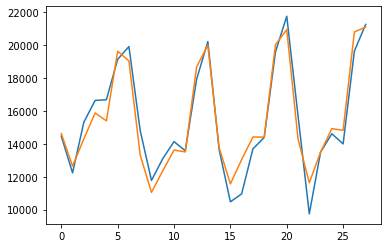

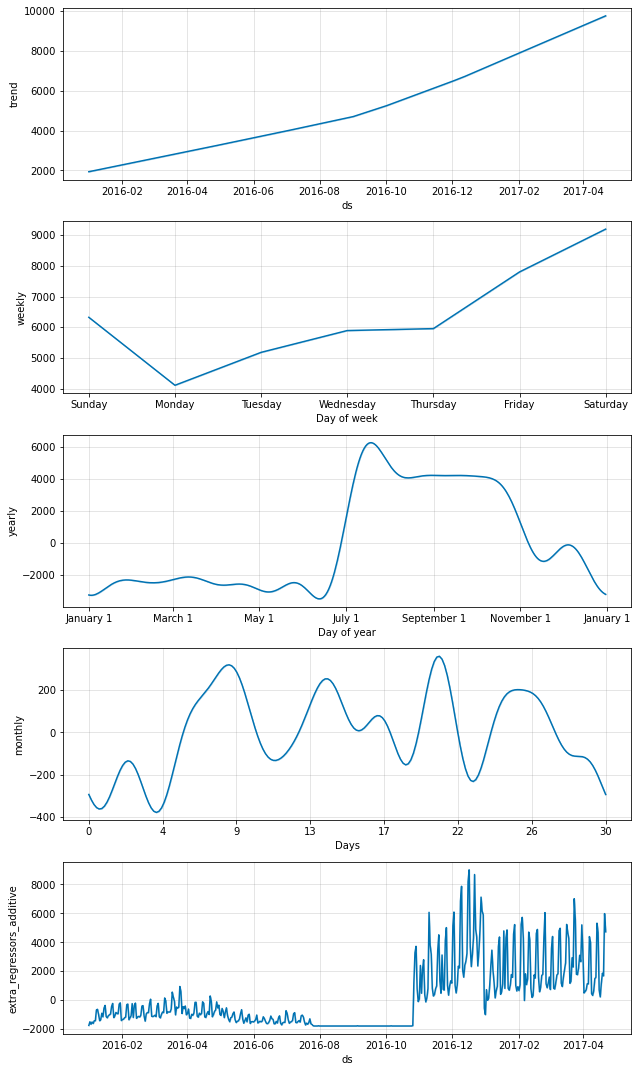

In [35]:
# las predicciones son bastante mejores
plt.plot(list(test['y']))
plt.plot(list(forecast5.loc[450:,'yhat'] ))

fig2 = m5.plot_components(forecast5)
plt.show()
# la componente de tendencia
# componente semanal
# componente anual
# componente mensual
# efecto que tiene las reservas sobre el modelo predictivo